# Notebook Contents

In this notebook, we will using deep-learning concepts and algorithms in order to detect the speaker's gender and emotion.

## Import Libraries

In [2]:
import os
import speech_recognition as sr
import librosa
import librosa.display
import pandas as pd
from scipy import signal
import IPython.display as ipd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Sequential, load_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential, Model
import keras
from keras import regularizers
from matplotlib.pyplot import specgram
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, Input, Flatten, Dropout, Activation, Conv1D,
                                                                            MaxPooling1D, AveragePooling1D
from keras import layers
from tensorflow.keras.regularizers import l2
import soundfile
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import confusion_matrix, accuracy_score

## Read Audio Files

Read audio files that were stored in an external directory called **audio speech actors**.

In [3]:
os.listdir(path='Audio_Speech_Actors')
def getListOfFiles(dirName):
    listOfFile=os.listdir(dirName)
    allFiles=list()
    for entry in listOfFile:
        fullPath=os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles=allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

dirName = 'Audio_Speech_Actors'
listOfFiles = getListOfFiles(dirName)
len(listOfFiles)

1441

## Drop DS File 

Drop unneeded file that doesn't impact the other files.

In [4]:
listOfFiles.pop(480)

'Audio_Speech_Actors/.DS_Store'

Extracting the data and the sampling rate from all audio files to create amplitude.<br>
**Sample Rate**:The sample rate is how many samples, or measurements, of the sound are taken each second.

In [5]:
def read_audio(list_audio):
    data_list=[]
    sampling_rate_list=[]
    normal_duration=[]
    for audio in list_audio:
        data, sampling_rate = librosa.load(audio)
        data_list.append(data)
        sampling_rate_list.append(sampling_rate)
        normal_duration.append(librosa.core.get_duration(data,sampling_rate))
    return data_list, sampling_rate_list,normal_duration
data_list, sampling_rate_list, duration=read_audio(listOfFiles)

## Create DataFrame 

The breakdown for each audio path

**03-01-05-01-02-01-16.wav**

Modality -> (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel -> (01 = speech, 02 = song).

Emotion -> (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity -> (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement -> (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition -> (01 = 1st repetition, 02 = 2nd repetition).

Actor -> (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [6]:
# Determining the name of the columns
data = pd.DataFrame(columns=['Path', 'Emotion', 'Emotion_intensity','Statement','Gender', 'Duration']) 

In [7]:
# Accessing the directories of each actor
speech_dir = 'Audio_Speech_Actors/'
actors = [dir for dir in os.listdir(speech_dir) if dir.startswith('Actor_')]
print(actors)

['Actor_16', 'Actor_11', 'Actor_18', 'Actor_20', 'Actor_21', 'Actor_19', 'Actor_10', 'Actor_17', 'Actor_04', 'Actor_03', 'Actor_02', 'Actor_05', 'Actor_12', 'Actor_15', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_14', 'Actor_13', 'Actor_09', 'Actor_07', 'Actor_06', 'Actor_01', 'Actor_08']


## Filling the dataframe

In [8]:
# Iterated through every data folders and the data 
for dir in actors:
    act_dir = os.path.join(speech_dir,dir)
    for wav in os.listdir(act_dir):
        # get file name with labels
        identifiers = wav.split('.')[0].split('-')
        # Extracted file name and stored it in list after spliting
        emotion = (int(identifiers[2]))
        # lable corrsponding to emotion is stored in variable emotion
        emotion_intensity = (int(identifiers[3]))
        if int(identifiers[6])%2 == 0:
            gender = 'female'
        else:
            gender = 'male'
        # extracted gender lable based on label value (even for female and odd for male)
        statement = (int(identifiers[4]))
        # extract statement 
        file_path = os.path.join(act_dir, wav).replace("\\","/")
        # chage the path representation in windows
        data = data.append({"Path": file_path,
                            "Emotion": emotion,
                            "Emotion_intensity": emotion_intensity,
                            "Statement": statement,
                            "Gender": gender,
                             },
                             ignore_index = True
                          )
data['Duration']= duration
        # Append the extrated labels to data frame.

In [9]:
def label_emotion(emotion):
    """
    This method is called to label the emotion into one of 8 categories.
    """
    if emotion == 1 :
        return 'neutral'
    elif emotion == 2:
        return 'calm'
    elif emotion == 3:
        return 'happy'
    elif emotion == 4:
        return 'sad'
    elif emotion == 5:
        return 'angry'
    elif emotion == 6:
        return 'fearful'
    elif emotion == 7:
        return 'disgust'
    else: 
        return 'surprised'

In [10]:
data['Emotion']= data.Emotion.apply(label_emotion)

In [11]:
def label_statement(statement):
    """
    This method is called to label the statement into one of 2 categories.
    """
    if statement == 1 :
        return 'kids'
    else: 
        return 'dogs'

In [12]:
data['Statement']= data.Statement.apply(label_statement)

In [13]:
def label_intensity(intensity):
    """
    This method is called to label the intensity into one of 2 categories.
    """
    if intensity == 1 :
        return 'normal'
    else: 
        return 'strong'

In [14]:
data['Emotion_intensity']= data.Emotion_intensity.apply(label_intensity)

In [15]:
def target(gender, emotion):
    """
    This method is called to label the statement into one of 2 categories.
    """
    return gender+'_'+emotion 

In [16]:
data['Target']= data.apply(lambda x: target(x.Gender, x.Emotion), axis=1)

In [17]:
data['audio_data']= data_list

In [18]:
data.head()

Path  Emotion  \
0  Audio_Speech_Actors/Actor_16/03-01-05-01-02-01...    angry   
1  Audio_Speech_Actors/Actor_16/03-01-06-01-02-02...  fearful   
2  Audio_Speech_Actors/Actor_16/03-01-06-02-01-02...  fearful   
3  Audio_Speech_Actors/Actor_16/03-01-05-02-01-01...    angry   
4  Audio_Speech_Actors/Actor_16/03-01-07-01-01-01...  disgust   

  Emotion_intensity Statement  Gender  Duration          Target  \
0            normal      dogs  female  3.903900    female_angry   
1            normal      dogs  female  3.570249  female_fearful   
2            strong      kids  female  3.737098  female_fearful   
3            strong      kids  female  3.970658    female_angry   
4            normal      kids  female  3.770476  female_disgust   

                                          audio_data  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [3.0036153e-05, 2.7443759e-05, 9.890327e-07, 6...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

## EDA Graphs

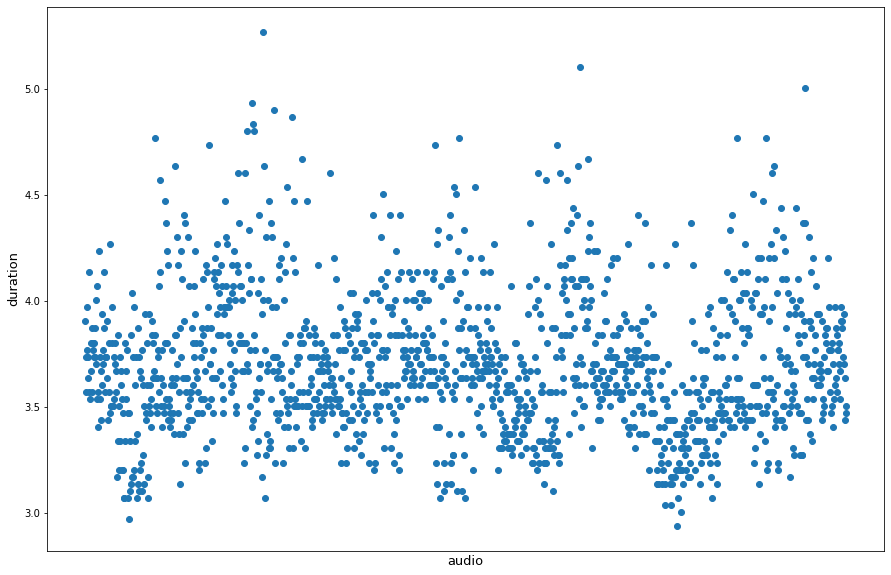

In [19]:
plt.rcParams["figure.figsize"] = (15,10)
audio_path = data['Path']
duration = data['Duration']
plt.xlabel("audio",fontsize=13);
plt.ylabel("duration",fontsize=13);
plt.xticks([])
plt.scatter(audio_path,duration)
plt.show()

In the graph shown above, the duration was plotted along with each audio.

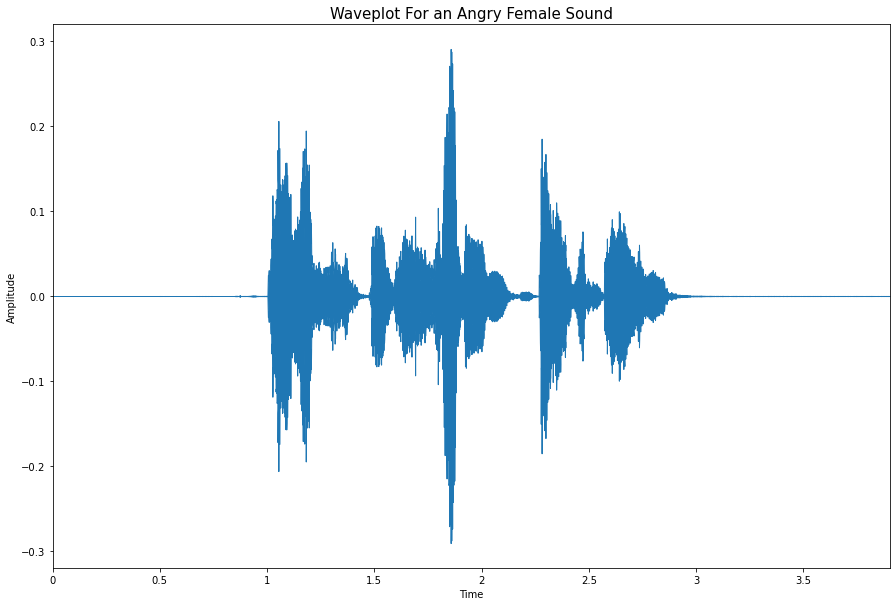

In [20]:
librosa.display.waveplot(data['audio_data'][0],sr=sampling_rate_list[0]);
plt.ylabel("Amplitude")
plt.title('Waveplot For an Angry Female Sound', fontsize=15);

Wave plot for an **Angry Female**

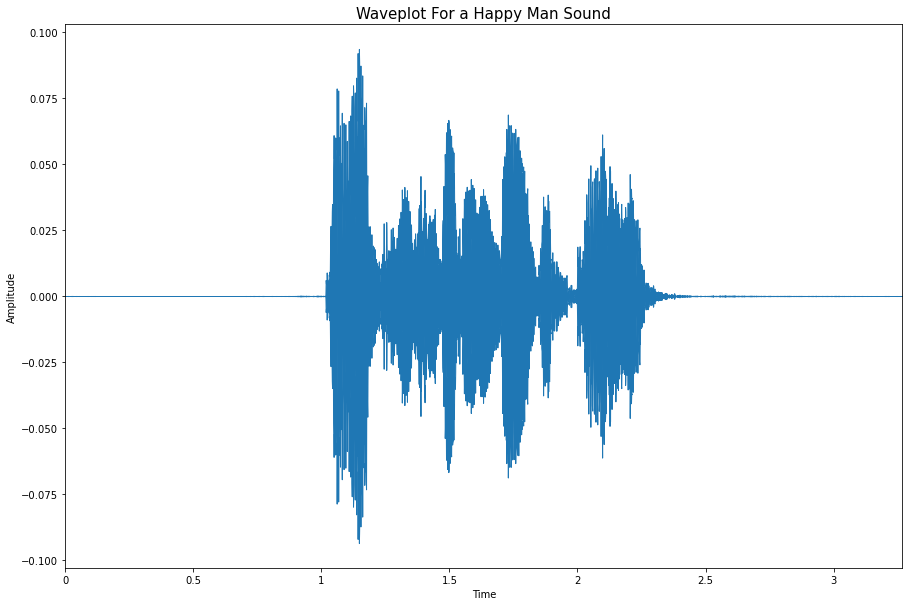

In [21]:
librosa.display.waveplot(data['audio_data'][853],sr=sampling_rate_list[0]);
plt.ylabel("Amplitude")
plt.title('Waveplot For a Happy Man Sound', fontsize=15);

Wave plot for an **Happy Male**

## Spectrograms 

Gets the logged value in order to further sepicify spectrograms.

In [22]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [23]:
filename = data.Path[0]

Text(0.5, 0, 'Seconds')

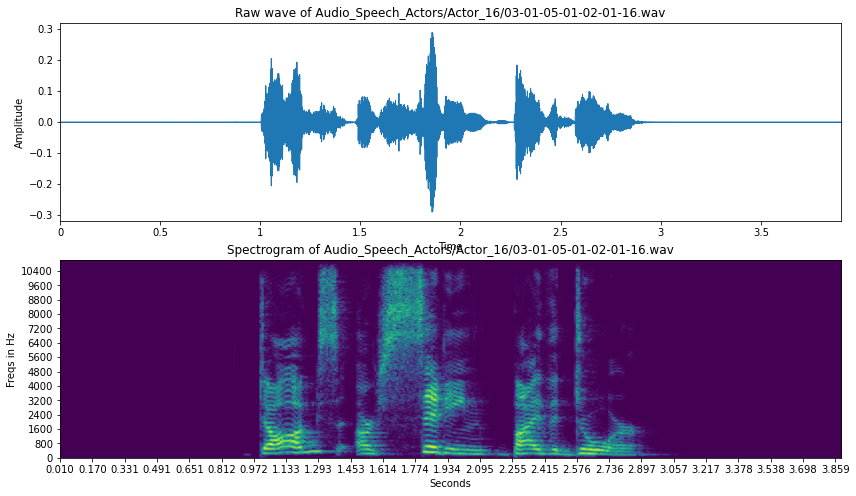

In [24]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(data_list[0], sampling_rate_list[0])

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(data_list[0], sr=sampling_rate_list[0])

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [25]:
# Normalizing the values of spectrograms.
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [26]:
# Trim the silence voice
aa , bb = librosa.effects.trim(data_list[0], top_db=30)
aa, bb

(array([-1.8758229e-04, -1.1675138e-04, -1.1105111e-04, ...,
        -5.7289176e-06,  1.3341569e-05, -1.0213388e-04], dtype=float32),
 array([21504, 64000]))

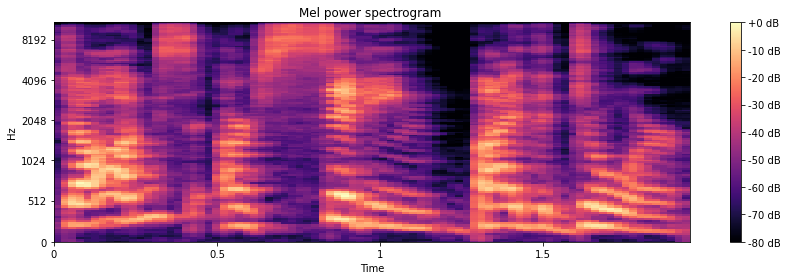

In [27]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sampling_rate_list[0], n_mels=128)

# Convert to log scale (dB). use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sampling_rate_list[0], x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

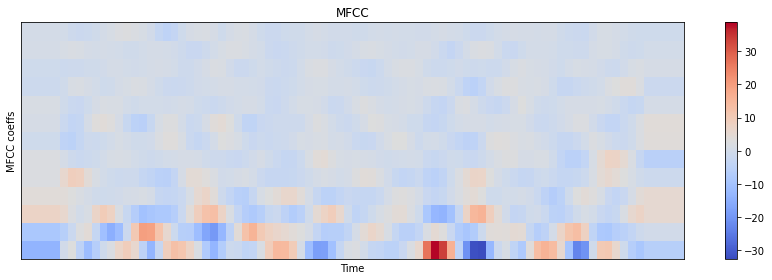

In [28]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [29]:
# Confirm & Compare shapes
S.shape

(128, 84)

In [30]:
# Confirm & Compare shapes
mfcc.shape

(13, 84)

## Features Extraction 

Extracting the features from audio waves by using the MFCC (Mel-frequency cepstrum)

In [31]:
from tqdm import tqdm
input_duration=3

audio = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data))):
    X, sample_rate = librosa.load(data.Path[i],
                                  res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    audio.loc[i] = [feature]

100%|██████████| 1440/1440 [01:30<00:00, 15.84it/s]


In [32]:
audio

feature
0     [-55.07453, -55.07453, -55.07453, -55.07453, -...
1     [-54.388466, -54.388466, -54.388466, -54.38846...
2     [-42.791096, -42.925762, -42.899185, -42.68892...
3     [-45.452774, -45.452774, -45.452774, -45.45277...
4     [-62.8723, -62.8723, -62.8723, -62.8723, -62.8...
...                                                 ...
1435  [-52.7948, -53.763607, -55.00385, -54.96499, -...
1436  [-53.335293, -54.241184, -52.663242, -53.00668...
1437  [-55.19314, -55.72388, -56.97952, -60.7733, -5...
1438  [-62.298923, -58.117092, -52.51449, -49.66577,...
1439  [-53.71832, -55.116398, -54.395218, -54.102036...

[1440 rows x 1 columns]

In [33]:
featurs_data = pd.DataFrame(audio['feature'].values.tolist())
Target = data.Target
Path= data.Path

In [34]:
featurs_data = pd.concat([featurs_data,Target,Path], axis=1)

In [35]:
featurs_data.isna().sum()

0           0
1           0
2           0
3           0
4           0
         ... 
256       377
257       377
258       377
Target      0
Path        0
Length: 261, dtype: int64

In [36]:
featurs_data.fillna(0, inplace=True)

In [37]:
featurs_data.isna().sum()

0         0
1         0
2         0
3         0
4         0
         ..
256       0
257       0
258       0
Target    0
Path      0
Length: 261, dtype: int64

## Augmentation on raw data

Augmentation methods on raw audio to generlize the model and increase the data size.

In [38]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

Audio before augemntation methods

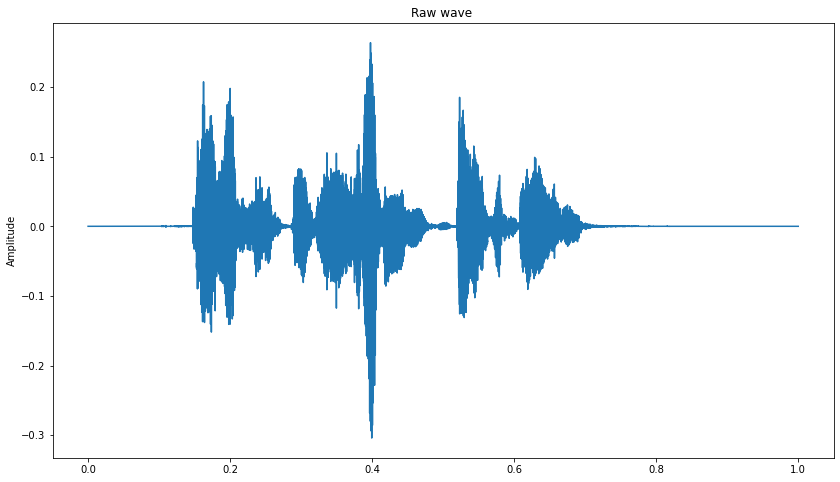

In [39]:
X, sample_rate = librosa.load(data.Path[0], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

Audio after pitched

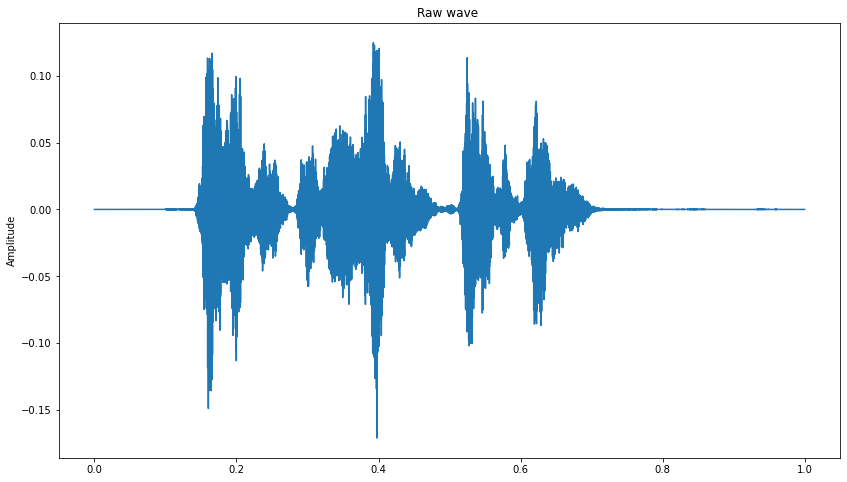

In [40]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)
# Pitched audio

Audio after adding noise 

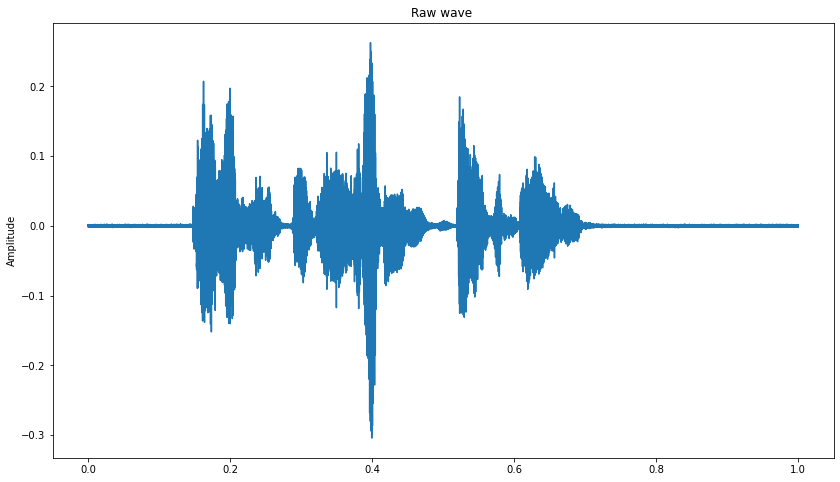

In [41]:
x = noise(X)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)
# Added noise

Audio after stretched 

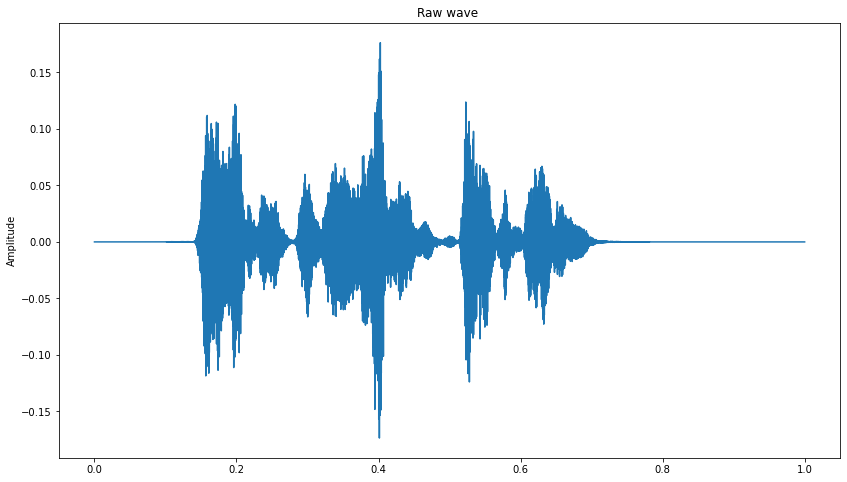

In [42]:
x = stretch(X,rate=0.6)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)
# Stretched audio

### Create Augmented DataFrames 

In [43]:
# Augmentation Method 1
syn_data1 = pd.DataFrame(columns=['Path','Feature', 'Target'])
for i in tqdm(range(len(data))):
    X, sample_rate = librosa.load(data.Path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data.Target[i]:
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        path = f'augment_audios/syn_data1_{i}.wav'
        syn_data1.loc[i] = [path,feature, data.Target[i]]
        soundfile.write(f'{path}',X,sample_rate)

100%|██████████| 1440/1440 [02:04<00:00, 11.56it/s]


In [44]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['Path','Feature', 'Target'])
for i in tqdm(range(len(data))):
    X, sample_rate = librosa.load(data.Path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data.Target[i]:
        X = stretch(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        path = f'augment_audios/syn_data2_{i}.wav'
        syn_data2.loc[i] = [path,feature, data.Target[i]]
        soundfile.write(f'{path}',X,sample_rate)

100%|██████████| 1440/1440 [03:39<00:00,  6.55it/s]


In [45]:
# Augmentation Method 3

syn_data3 = pd.DataFrame(columns=['Path','Feature', 'Target'])
for i in tqdm(range(len(data))):
    X, sample_rate = librosa.load(data.Path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data.Target[i]:
        X = shift(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        path = f'augment_audios/syn_data3_{i}.wav'
        syn_data3.loc[i] = [path,feature, data.Target[i]]
        soundfile.write(f'{path}',X,sample_rate)

100%|██████████| 1440/1440 [01:49<00:00, 13.10it/s]


In [46]:
# Augmentation Method 4

syn_data4 = pd.DataFrame(columns=['Path','Feature', 'Target'])
for i in tqdm(range(len(data))):
    X, sample_rate = librosa.load(data.Path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data.Target[i]:
        X = pitch(X,sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        path = f'augment_audios/syn_data4_{i}.wav'
        syn_data4.loc[i] = [path,feature, data.Target[i]]
        soundfile.write(f'{path}',X,sample_rate)

100%|██████████| 1440/1440 [07:36<00:00,  3.16it/s]


In [47]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)
syn_data3 = syn_data3.reset_index(drop=True)
syn_data4 = syn_data4.reset_index(drop=True)

In [48]:
df4 = pd.DataFrame(syn_data1['Feature'].values.tolist())
labels4 = syn_data1.Target
paths1= syn_data1.Path
syndf1 = pd.concat([df4,labels4,paths1], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "Target"})
syndf1 = syndf1.fillna(0)

In [49]:
df5 = pd.DataFrame(syn_data2['Feature'].values.tolist())
labels5 = syn_data2.Target
paths2= syn_data2.Path
syndf2 = pd.concat([df5,labels5,paths2], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "Target"})
syndf2 = syndf2.fillna(0)

In [50]:
df6 = pd.DataFrame(syn_data3['Feature'].values.tolist())
labels6 = syn_data3.Target
paths3= syn_data3.Path
syndf3 = pd.concat([df6,labels6,paths3], axis=1)
syndf3 = syndf3.rename(index=str, columns={"0": "Target"})
syndf3 = syndf3.fillna(0)

In [51]:
df7 = pd.DataFrame(syn_data4['Feature'].values.tolist())
labels7 = syn_data4.Target
paths4 = syn_data4.Path
syndf4 = pd.concat([df7,labels7,paths4], axis=1)
syndf4 = syndf4.rename(index=str, columns={"0": "Target"})
syndf4 = syndf4.fillna(0)

In [52]:
# Combining the Augmented data with original
combined_df = pd.concat([featurs_data, syndf1, syndf2,syndf3,syndf4], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df

0          1          2          3          4          5    \
0    -55.074532 -55.074532 -55.074532 -55.074532 -55.074532 -55.074532   
1    -54.388466 -54.388466 -54.388466 -54.388466 -54.388466 -54.388466   
2    -42.791096 -42.925762 -42.899185 -42.688927 -42.425762 -42.087055   
3    -45.452774 -45.452774 -45.452774 -45.452774 -45.452774 -45.452774   
4    -62.872299 -62.872299 -62.872299 -62.872299 -62.872299 -62.872299   
...         ...        ...        ...        ...        ...        ...   
7195 -53.325728 -54.657024 -55.640690 -56.400576 -56.436258 -55.851302   
7196 -53.751259 -55.531686 -54.850154 -53.676848 -54.322561 -53.360454   
7197 -55.328049 -56.549501 -58.571428 -59.385126 -59.941022 -57.713398   
7198 -60.476809 -58.011229 -55.429079 -53.340511 -51.912651 -53.584429   
7199 -53.520368 -54.764450 -54.756290 -55.320606 -56.271143 -55.115498   

            6          7          8          9    ...  313  314  315  316  \
0    -55.074532 -55.074532 -55.074532 -55.074532  ...  0.0  0.0  0.0  0.0   
1    -54.388466 -54.388466 -54.388466 -54.388466  ...  0.0  0.0  0.0  0.0   
2    -41.129875 -40.550945 -39.232639 -39.827827  ...  0.0  0.0  0.0  0.0   
3    -45.452774 -45.452774 -45.452774 -45.452774  ...  0.0  0.0  0.0  0.0   
4    -62.872299 -62.872299 -62.872299 -62.872299  ...  0.0  0.0  0.0  0.0   
...         ...        ...        ...        ...  ...  ...  ...  ...  ...   
7195 -55.767353 -54.349483 -54.940813 -54.574537  ...  0.0  0.0  0.0  0.0   
7196 -53.523519 -54.517294 -53.529807 -52.628137  ...  0.0  0.0  0.0  0.0   
7197 -55.104045 -56.385906 -57.719762 -58.623155  ...  0.0  0.0  0.0  0.0   
7198 -54.316560 -53.571969 -53.902548 -55.898431  ...  0.0  0.0  0.0  0.0   
7199 -53.463728 -55.430091 -53.729792 -55.307871  ...  0.0  0.0  0.0  0.0   

      317  318  319  320  321  322  
0     0.0  0.0  0.0  0.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  0.0  0.0  
2     0.0  0.0  0.0  0.0  0.0  0.0  
3     0.0  0.0  0.0  0.0  0.0  0.0  
4     0.0  0.0  0.0  0.0  0.0  0.0  
...   ...  ...  ...  ...  ...  ...  
7195  0.0  0.0  0.0  0.0  0.0  0.0  
7196  0.0  0.0  0.0  0.0  0.0  0.0  
7197  0.0  0.0  0.0  0.0  0.0  0.0  
7198  0.0  0.0  0.0  0.0  0.0  0.0  
7199  0.0  0.0  0.0  0.0  0.0  0.0  

[7200 rows x 325 columns]

As shown above, the dataframe rows increased from **1440** to **7200** due to the audio augmentation. 

## Data Splitting

In [53]:
X= combined_df.drop(['Target','Path'], axis=1)
y= combined_df.Target

In [54]:
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()

In [55]:
# 20% vs 80%
X_train , X_test, y_train,y_test = train_test_split(X,y, test_size=.2, random_state= 42)
X_train , X_val, y_train,y_val = train_test_split(X_train,y_train, test_size=.25, random_state= 42)

In [56]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, y_train.shape, X_test.shape, y_test.shape,X_val.shape, y_val.shape

((4320, 323), (4320, 16), (1440, 323), (1440, 16), (1440, 323), (1440, 16))

In [57]:
# RESHAPE DATA TO INCLUDE 3D TENSOR 
X_traind = X_train[:,:,np.newaxis]
X_testd = X_test[:,:,np.newaxis]
X_vald = X_val[:,:,np.newaxis]

In [58]:
X_traind.shape, y_train.shape, X_testd.shape, y_test.shape,X_vald.shape, y_val.shape

((4320, 323, 1),
 (4320, 16),
 (1440, 323, 1),
 (1440, 16),
 (1440, 323, 1),
 (1440, 16))

# Baseline Classification

### DecisionTreeClassifier

In [453]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
tr_score=clf.score(X_train,y_train)
val_score=clf.score(X_val,y_val)
test_score=clf.score(X_test,y_test)
clf.predict(X_test)
combined_X = np.concatenate((X_train, X_val))
combined_y = np.concatenate((y_train, y_val))
Whole_data = clf.score(combined_X,combined_y)
print('Training Score:',tr_score)
print('Training + Validation Score:',Whole_data)
print('Validation Score:',val_score)
print('Testing Score:',test_score)

Training Score: 1.0
Training + Validation Score: 0.8326388888888889
Validation Score: 0.33055555555555555
Testing Score: 0.3576388888888889


The training score is **1.0** but the validation score is **0.3**, so the scores are very low and also there is overfitting.

### KNeighborsClassifier

In [454]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=70)
knn = knn.fit(X_train, y_train)
tr_score=knn.score(X_train,y_train)
val_score=knn.score(X_val,y_val)
test_score=knn.score(X_test,y_test)
knn.predict(X_test)
combined_X = np.concatenate((X_train, X_val))
combined_y = np.concatenate((y_train, y_val))
Whole_data = knn.score(combined_X,combined_y)
print('Training Score:',tr_score)
print('Training + Validation Score:',Whole_data)
print('Validation Score:',val_score)
print('Testing Score:',test_score)

Training Score: 0.03009259259259259
Training + Validation Score: 0.028993055555555557
Validation Score: 0.025694444444444443
Testing Score: 0.016666666666666666


The training score is **0.03**, and the validation score is **0.02**. Tthe scores are very low.

Since data is considered non-tabular, the best way to deal with it is by using Neural Network Models.

## Neural Networks Models 

## First Model

## FeedForward NN

###  Baseline Traditional NN

In [545]:
base_model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    keras.layers.Dense(units=500,activation='relu'),
    keras.layers.Dense(units=300,activation='relu'),
    keras.layers.Dense(units=200,activation='relu'),
    keras.layers.Dense(units=16,activation='softmax')
])
base_model.compile('sgd',loss='mean_absolute_error',metrics=['categorical_accuracy'])
base_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_94 (Dense)            (None, 500)               162000    
                                                                 
 dense_95 (Dense)            (None, 300)               150300    
                                                                 
 dense_96 (Dense)            (None, 200)               60200     
                                                                 
 dense_97 (Dense)            (None, 16)                3216      
                                                                 
Total params: 375,716
Trainable params: 375,716
Non-trainable params: 0
_________________________________________________________________


In [546]:
history04=base_model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
68/68 [==============================] - 2s 10ms/step - loss: 0.1168 - categorical_accuracy: 0.0826 - val_loss: 0.1167 - val_categorical_accuracy: 0.0854
Epoch 2/50
68/68 [==============================] - 0s 7ms/step - loss: 0.1167 - categorical_accuracy: 0.0882 - val_loss: 0.1166 - val_categorical_accuracy: 0.0896
Epoch 3/50
68/68 [==============================] - 0s 6ms/step - loss: 0.1167 - categorical_accuracy: 0.0938 - val_loss: 0.1165 - val_categorical_accuracy: 0.0924
Epoch 4/50
68/68 [==============================] - 1s 8ms/step - loss: 0.1166 - categorical_accuracy: 0.0977 - val_loss: 0.1165 - val_categorical_accuracy: 0.0944
Epoch 5/50
68/68 [==============================] - 0s 6ms/step - loss: 0.1165 - categorical_accuracy: 0.1019 - val_loss: 0.1164 - val_categorical_accuracy: 0.0972
Epoch 6/50
68/68 [==============================] - 1s 8ms/step - loss: 0.1164 - categorical_accuracy: 0.1039 - val_loss: 0.1163 - val_categorical_accuracy: 0.1035
Epoch 7/50
68/6

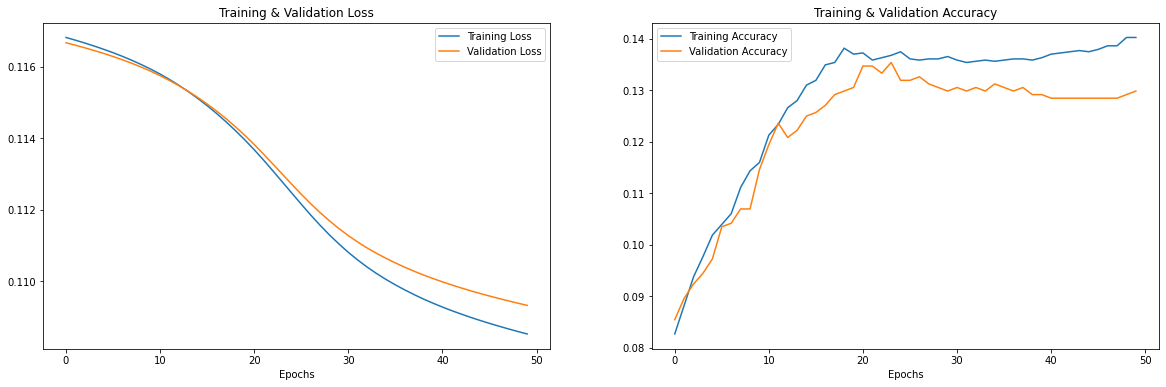

In [547]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history04.history['categorical_accuracy']
train_loss = history04.history['loss']
val_acc = history04.history['val_categorical_accuracy']
val_loss = history04.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , val_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , val_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

As seen, the training score is **0.14** and the validation score is almost **0.13**. Since the scores are very low, we will try to increase the model complexity.   

## Baseline with more layers 

In [73]:
base_model2 = keras.Sequential([
    keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    keras.layers.Dense(units=800,activation='relu'),
    keras.layers.Dense(units=600,activation='relu'),
    keras.layers.Dense(units=500,activation='relu'),
    keras.layers.Dense(units=400,activation='relu'),
    keras.layers.Dense(units=200,activation='relu'),
    keras.layers.Dense(units=128,activation='relu'),
    keras.layers.Dense(units=90,activation='relu'),
    keras.layers.Dense(units=46,activation='relu'),
    keras.layers.Dense(units=16,activation='softmax')
])
base_model2.compile('sgd',loss='mean_absolute_error',metrics=['categorical_accuracy'])
base_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 800)               259200    
                                                                 
 dense_5 (Dense)             (None, 600)               480600    
                                                                 
 dense_6 (Dense)             (None, 500)               300500    
                                                                 
 dense_7 (Dense)             (None, 400)               200400    
                                                                 
 dense_8 (Dense)             (None, 200)               80200     
                                                                 
 dense_9 (Dense)             (None, 128)               25728     
                                                                 
 dense_10 (Dense)            (None, 90)               

In [74]:
history03=base_model2.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
68/68 [==============================] - 2s 24ms/step - loss: 0.1172 - categorical_accuracy: 0.0417 - val_loss: 0.1172 - val_categorical_accuracy: 0.0403
Epoch 2/50
68/68 [==============================] - 1s 19ms/step - loss: 0.1172 - categorical_accuracy: 0.0410 - val_loss: 0.1172 - val_categorical_accuracy: 0.0410
Epoch 3/50
68/68 [==============================] - 1s 19ms/step - loss: 0.1172 - categorical_accuracy: 0.0412 - val_loss: 0.1172 - val_categorical_accuracy: 0.0410
Epoch 4/50
68/68 [==============================] - 1s 20ms/step - loss: 0.1172 - categorical_accuracy: 0.0414 - val_loss: 0.1172 - val_categorical_accuracy: 0.0417
Epoch 5/50
68/68 [==============================] - 1s 20ms/step - loss: 0.1172 - categorical_accuracy: 0.0412 - val_loss: 0.1172 - val_categorical_accuracy: 0.0437
Epoch 6/50
68/68 [==============================] - 1s 21ms/step - loss: 0.1172 - categorical_accuracy: 0.0412 - val_loss: 0.1172 - val_categorical_accuracy: 0.0451
Epoch 7/50

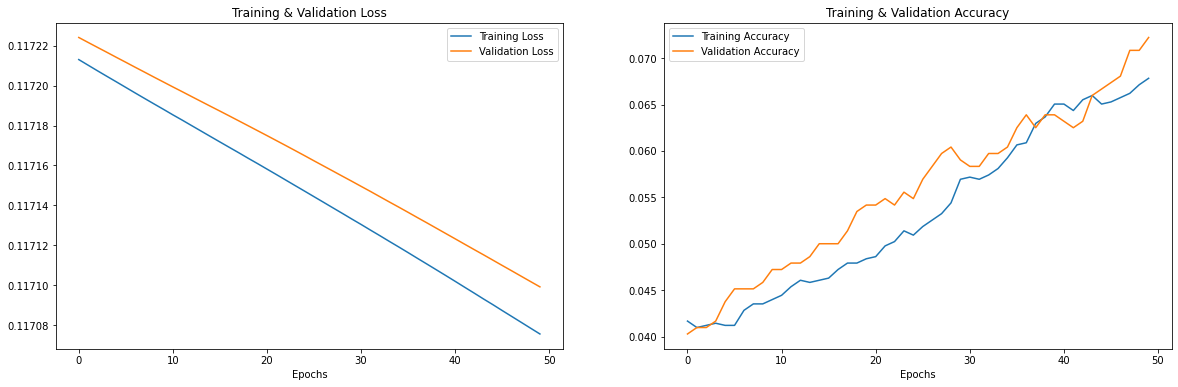

In [75]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history03.history['categorical_accuracy']
train_loss = history03.history['loss']
val_acc = history03.history['val_categorical_accuracy']
val_loss = history03.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , val_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , val_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

Oops! the scores are decreased. The training score has become **0.0678**, and the validation **0.0722**. So, we will try another model. 

### CNN Simple 

In [76]:
model1 = Sequential()
model1.add(Conv1D(256, 8, padding='same',input_shape=(X_traind.shape[1],1)))
model1.add(Activation('relu'))
model1.add(Conv1D(256, 8, padding='same'))
model1.add(Activation('relu'))
model1.add(layers.Flatten())
model1.add(Dense(16))
model1.add(Activation('softmax'))

opt = tf.keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
model1.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['categorical_accuracy'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 323, 256)          2304      
                                                                 
 activation (Activation)     (None, 323, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 323, 256)          524544    
                                                                 
 activation_1 (Activation)   (None, 323, 256)          0         
                                                                 
 flatten (Flatten)           (None, 82688)             0         
                                                                 
 dense_13 (Dense)            (None, 16)                1323024   
                                                                 
 activation_2 (Activation)   (None, 16)               

/Users/amjad/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [77]:
history02=model1.fit(X_traind, y_train, batch_size=64, epochs=50, validation_data=(X_vald, y_val))

Epoch 1/50
68/68 [==============================] - 76s 1s/step - loss: 2.7792 - categorical_accuracy: 0.0646 - val_loss: 2.7731 - val_categorical_accuracy: 0.0674
Epoch 2/50
68/68 [==============================] - 74s 1s/step - loss: 2.7714 - categorical_accuracy: 0.0745 - val_loss: 2.7661 - val_categorical_accuracy: 0.0819
Epoch 3/50
68/68 [==============================] - 75s 1s/step - loss: 2.7639 - categorical_accuracy: 0.1023 - val_loss: 2.7593 - val_categorical_accuracy: 0.1097
Epoch 4/50
68/68 [==============================] - 79s 1s/step - loss: 2.7564 - categorical_accuracy: 0.1269 - val_loss: 2.7526 - val_categorical_accuracy: 0.1278
Epoch 5/50
68/68 [==============================] - 83s 1s/step - loss: 2.7491 - categorical_accuracy: 0.1398 - val_loss: 2.7459 - val_categorical_accuracy: 0.1312
Epoch 6/50
68/68 [==============================] - 72s 1s/step - loss: 2.7419 - categorical_accuracy: 0.1421 - val_loss: 2.7394 - val_categorical_accuracy: 0.1368
Epoch 7/50
68/68

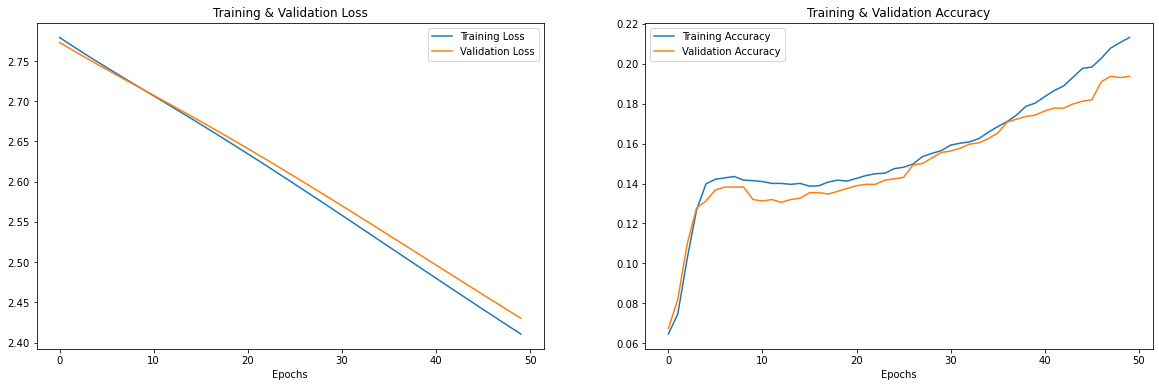

In [78]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history02.history['categorical_accuracy']
train_loss = history02.history['loss']
val_acc = history02.history['val_categorical_accuracy']
val_loss = history02.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , val_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , val_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

As seen, the scores are slightly increased. The training has become **0.21**, and the validation **0.19**. So, we will try to increase the model complexity.

### CNN Complex

In [81]:
# New model
from keras.layers import BatchNormalization
model2 = Sequential()
model2.add(Conv1D(256, 8, padding='same',input_shape=(X_traind.shape[1],1)))
model2.add(Activation('relu'))
model2.add(Conv1D(256, 8, padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.25))
model2.add(MaxPooling1D(pool_size=(8)))
model2.add(Conv1D(128, 8, padding='same'))
model2.add(Activation('relu'))
model2.add(Conv1D(128, 8, padding='same'))
model2.add(Activation('relu'))
model2.add(Conv1D(128, 8, padding='same'))
model2.add(Activation('relu'))
model2.add(Conv1D(128, 8, padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.25))
model2.add(MaxPooling1D(pool_size=(8)))
model2.add(Conv1D(64, 8, padding='same'))
model2.add(Activation('relu'))
model2.add(Conv1D(64, 8, padding='same'))
model2.add(Activation('relu'))
model2.add(Flatten())
# Edit according to target class no.
model2.add(Dense(16))
model2.add(Activation('softmax'))
opt = tf.keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

In [82]:
model2.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['categorical_accuracy'])

In [83]:
history01=model2.fit(X_traind, y_train, batch_size=64, epochs=50, validation_data=(X_vald, y_val))

Epoch 1/50
68/68 [==============================] - 83s 1s/step - loss: 2.8319 - categorical_accuracy: 0.0880 - val_loss: 2.7725 - val_categorical_accuracy: 0.0576
Epoch 2/50
68/68 [==============================] - 85s 1s/step - loss: 2.7529 - categorical_accuracy: 0.1058 - val_loss: 2.7741 - val_categorical_accuracy: 0.0576
Epoch 3/50
68/68 [==============================] - 127s 2s/step - loss: 2.6975 - categorical_accuracy: 0.1211 - val_loss: 2.7765 - val_categorical_accuracy: 0.0576
Epoch 4/50
68/68 [==============================] - 83s 1s/step - loss: 2.6535 - categorical_accuracy: 0.1243 - val_loss: 2.7769 - val_categorical_accuracy: 0.0576
Epoch 5/50
68/68 [==============================] - 80s 1s/step - loss: 2.6190 - categorical_accuracy: 0.1405 - val_loss: 2.7713 - val_categorical_accuracy: 0.0590
Epoch 6/50
68/68 [==============================] - 80s 1s/step - loss: 2.5843 - categorical_accuracy: 0.1507 - val_loss: 2.7561 - val_categorical_accuracy: 0.0688
Epoch 7/50
68/6

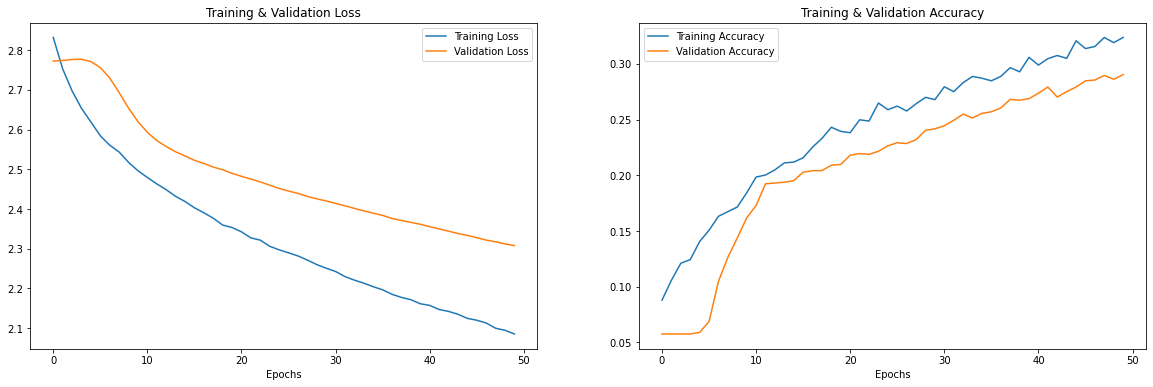

In [84]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history01.history['categorical_accuracy']
train_loss = history01.history['loss']
val_acc = history01.history['val_categorical_accuracy']
val_loss = history01.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , val_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , val_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

The scores are increased, the training score become **0.32**, and the validation **0.29**. We will try another way to increase the model complexity.

## CNN Complex Second Try

In [85]:
model3=Sequential()
model3.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_traind.shape[1], 1)))
model3.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model3.add(Dropout(0.5))

model3.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model3.add(Dropout(0.2))

model3.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model3.add(Dropout(0.2))

model3.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model3.add(Flatten())
model3.add(Dense(units=32, activation='relu'))
model3.add(Dropout(0.3))

model3.add(Dense(units=16, activation='softmax'))
model3.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['categorical_accuracy'])

model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 323, 256)          1536      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 162, 256)         0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 162, 256)          0         
                                                                 
 conv1d_11 (Conv1D)          (None, 162, 256)          327936    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 81, 256)          0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 81, 256)          

In [86]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history0=model3.fit(X_traind, y_train, batch_size=30, epochs=50, validation_data=(X_vald, y_val), callbacks=[rlrp])

Epoch 1/50
144/144 [==============================] - 39s 263ms/step - loss: 2.5857 - categorical_accuracy: 0.1391 - val_loss: 2.4119 - val_categorical_accuracy: 0.2285 - lr: 0.0010
Epoch 2/50
144/144 [==============================] - 37s 257ms/step - loss: 2.3485 - categorical_accuracy: 0.1975 - val_loss: 2.2672 - val_categorical_accuracy: 0.2396 - lr: 0.0010
Epoch 3/50
144/144 [==============================] - 39s 274ms/step - loss: 2.2365 - categorical_accuracy: 0.2199 - val_loss: 2.0420 - val_categorical_accuracy: 0.2771 - lr: 0.0010
Epoch 4/50
144/144 [==============================] - 52s 364ms/step - loss: 2.1560 - categorical_accuracy: 0.2359 - val_loss: 2.0361 - val_categorical_accuracy: 0.2785 - lr: 0.0010
Epoch 5/50
144/144 [==============================] - 45s 314ms/step - loss: 2.1221 - categorical_accuracy: 0.2389 - val_loss: 2.0440 - val_categorical_accuracy: 0.3146 - lr: 0.0010
Epoch 6/50
144/144 [==============================] - 39s 273ms/step - loss: 2.0585 - cate

Epoch 46/50
144/144 [==============================] - 37s 260ms/step - loss: 1.2732 - categorical_accuracy: 0.5072 - val_loss: 1.3033 - val_categorical_accuracy: 0.5549 - lr: 4.0000e-04
Epoch 47/50
144/144 [==============================] - 37s 255ms/step - loss: 1.2821 - categorical_accuracy: 0.5074 - val_loss: 1.3099 - val_categorical_accuracy: 0.5465 - lr: 4.0000e-04
Epoch 48/50
144/144 [==============================] - 37s 259ms/step - loss: 1.2807 - categorical_accuracy: 0.5106 - val_loss: 1.3152 - val_categorical_accuracy: 0.5382 - lr: 4.0000e-04
Epoch 49/50
144/144 [==============================] - 38s 261ms/step - loss: 1.2291 - categorical_accuracy: 0.5238 - val_loss: 1.3009 - val_categorical_accuracy: 0.5493 - lr: 1.6000e-04
Epoch 50/50
144/144 [==============================] - 37s 257ms/step - loss: 1.2311 - categorical_accuracy: 0.5250 - val_loss: 1.2959 - val_categorical_accuracy: 0.5535 - lr: 1.6000e-04


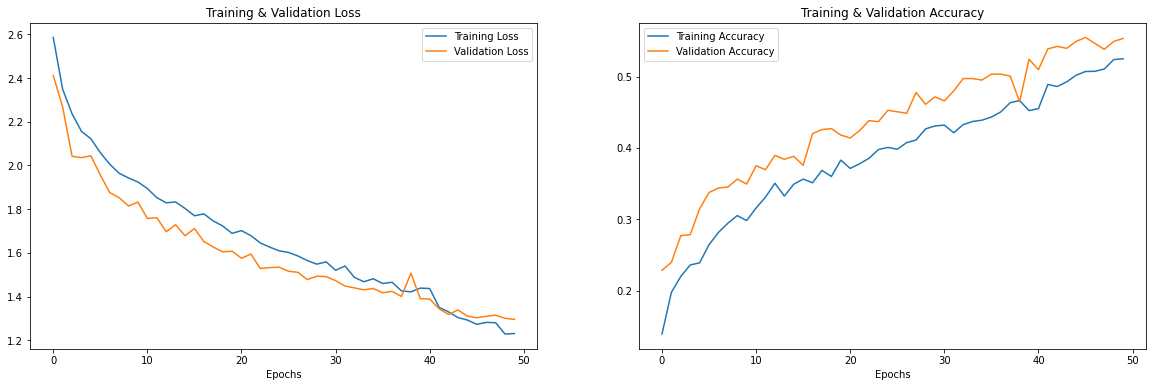

In [548]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history0.history['categorical_accuracy']
train_loss = history0.history['loss']
val_acc = history0.history['val_categorical_accuracy']
val_loss = history0.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , val_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , val_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

As we have seen, scores have been significantly increased. So, the training score become **0.52**, and the validation **0.55**. It is the highest score so far, but we will try another model to improve the scores. 

## LSTM

In [1155]:
model4 = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=9, strides=1, padding='same', input_shape=(X_traind.shape[1],1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Conv1D(filters=64, kernel_size=7, strides=1, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.LSTM(32, return_sequences=True),
    
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(units=16, activation='softmax')
        ])
model4._name= 'Baseline'
model4.summary()

Model: "Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_70 (Conv1D)          (None, 323, 32)           320       
                                                                 
 batch_normalization_56 (Bat  (None, 323, 32)          128       
 chNormalization)                                                
                                                                 
 activation_69 (Activation)  (None, 323, 32)           0         
                                                                 
 max_pooling1d_60 (MaxPoolin  (None, 161, 32)          0         
 g1D)                                                            
                                                                 
 dropout_88 (Dropout)        (None, 161, 32)           0         
                                                                 
 conv1d_71 (Conv1D)          (None, 161, 64)           144

In [1174]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-3, momentum=0.8)
model4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history00 = model4.fit(X_train, y_train, batch_size=30, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
144/144 [==============================] - 17s 86ms/step - loss: 1.1171 - categorical_accuracy: 0.6141 - val_loss: 1.3329 - val_categorical_accuracy: 0.5528
Epoch 2/50
144/144 [==============================] - 12s 86ms/step - loss: 1.0813 - categorical_accuracy: 0.6287 - val_loss: 1.3270 - val_categorical_accuracy: 0.5646
Epoch 3/50
144/144 [==============================] - 12s 82ms/step - loss: 1.0220 - categorical_accuracy: 0.6481 - val_loss: 1.3559 - val_categorical_accuracy: 0.5535
Epoch 4/50
144/144 [==============================] - 11s 80ms/step - loss: 0.9708 - categorical_accuracy: 0.6685 - val_loss: 1.3333 - val_categorical_accuracy: 0.5632
Epoch 5/50
144/144 [==============================] - 12s 87ms/step - loss: 0.9645 - categorical_accuracy: 0.6653 - val_loss: 1.3118 - val_categorical_accuracy: 0.5653
Epoch 6/50
144/144 [==============================] - 12s 81ms/step - loss: 0.9297 - categorical_accuracy: 0.6898 - val_loss: 1.3149 - val_categorical_accuracy:

144/144 [==============================] - 12s 82ms/step - loss: 0.5811 - categorical_accuracy: 0.8116 - val_loss: 1.1147 - val_categorical_accuracy: 0.6590
Epoch 50/50
144/144 [==============================] - 12s 83ms/step - loss: 0.5606 - categorical_accuracy: 0.8185 - val_loss: 1.1504 - val_categorical_accuracy: 0.6507


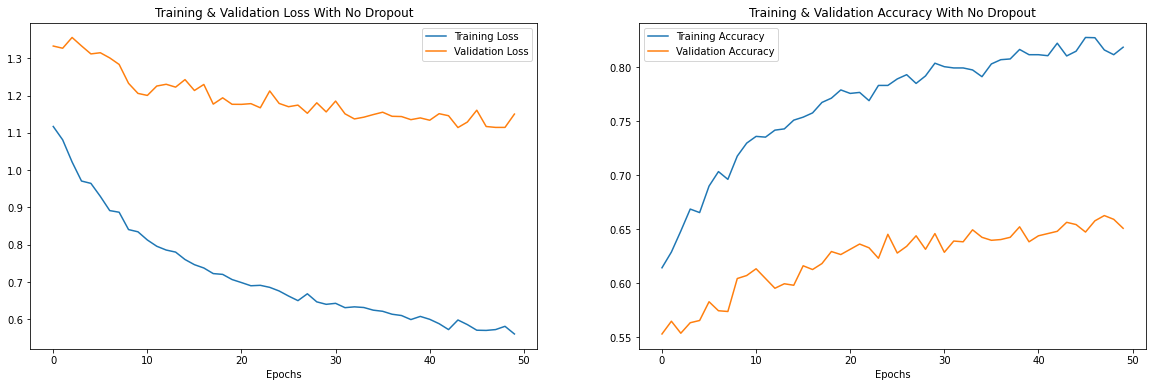

In [1175]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history00.history['categorical_accuracy']
train_loss = history00.history['loss']
val_acc = history00.history['val_categorical_accuracy']
val_loss = history00.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , val_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss With No Dropout')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , val_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy With No Dropout')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

Wow! The scores are significantly increased. The training score has become **0.81**, and the validation **0.65**. But it indicates that there is an overfit. So, we will try some overfitting solutions.

## Overfitting Solutions

In [550]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    opt = tf.keras.optimizers.SGD(learning_rate=0.09, decay=1e-3, momentum=0.8)

    model.compile(optimizer=opt
                  , loss='categorical_crossentropy'
                  , metrics=['categorical_accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=100
                       , batch_size=30
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history

In [551]:
def eval_metric(model, history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, 100 + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()

In [552]:
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

In [553]:
def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
    '''
    Function to compare a metric between two models 
    
    Parameters:
        model_hist_1 : training history of model 1
        model_hist_2 : training history of model 2
        metrix : metric to compare, loss, acc, val_loss or val_acc
        
    Output:
        plot of metrics of both models
    '''
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]
    e = range(1, 100 + 1)
    
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }
    
    metric_label = metrics_dict[metric]
    plt.plot(e, metric_model_1, 'bo', label=model_1.name)
    plt.plot(e, metric_model_2, 'b', label=model_2.name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()

In [554]:
def test_model(model, X_train, y_train, X_test, y_test, X_val , y_val ,epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=30
              , verbose=0)
    results1 = model.evaluate(X_train, y_train)
    results2 = model.evaluate(X_val, y_val)
    results3 = model.evaluate(X_test, y_test)

    print('Train accuracy: {0:.2f}%'.format(results1[1]*100))
    print()
    print('Validation accuracy: {0:.2f}%'.format(results2[1]*100))
    print()
    print('Test accuracy: {0:.2f}%'.format(results3[1]*100))
          
    return results1, results2, results3

Minimum validation loss reached in epoch 36


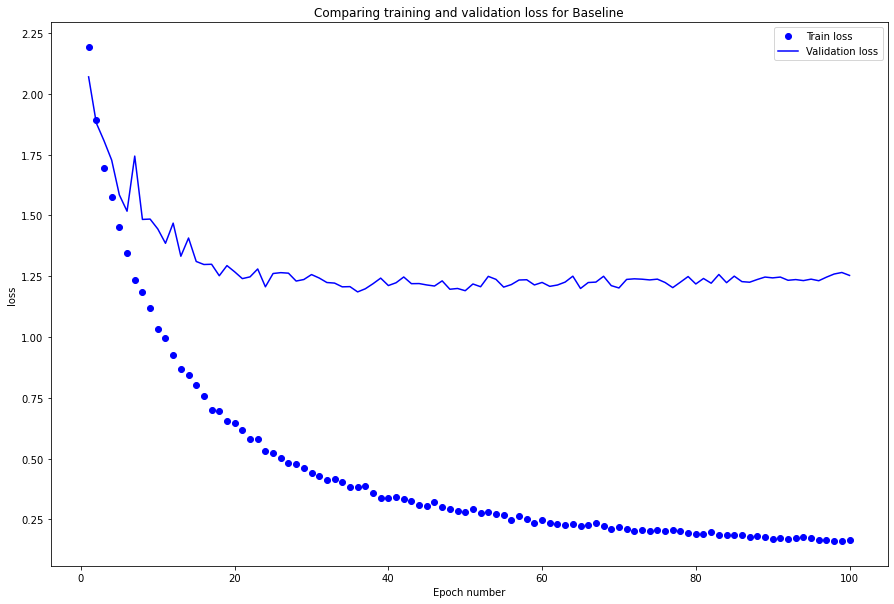

In [556]:
base_history = deep_model(model4, X_traind, y_train, X_vald, y_val)
base_min = optimal_epoch(base_history)
eval_metric(model4, base_history, 'loss')

The graph above presented the train and validation loss scores for **LSTM** model.

### Reduced Model 

In the first solution, we will try to use reduced model.

Minimum validation loss reached in epoch 18


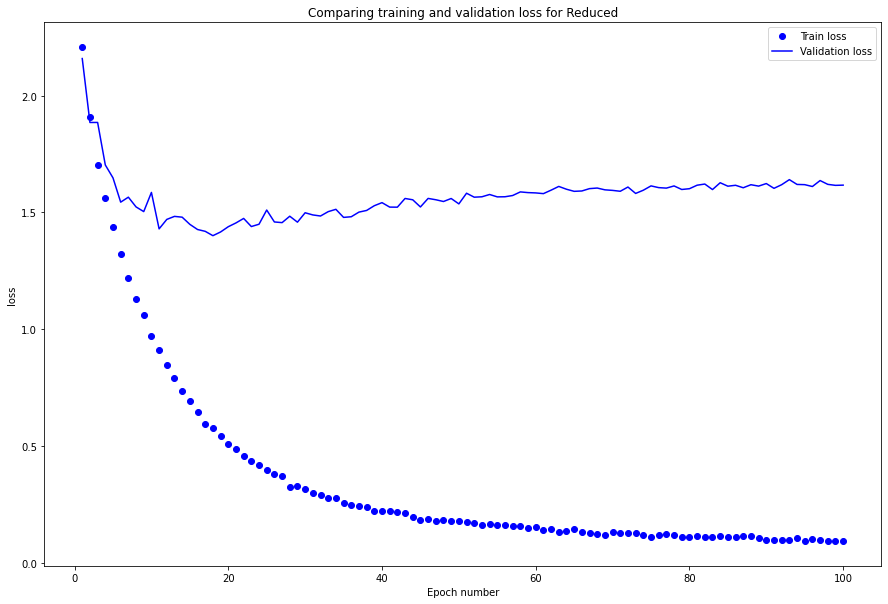

In [557]:
reduced_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=30, kernel_size=9, strides=1, padding='same', input_shape=(X_traind.shape[1],1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Conv1D(filters=50, kernel_size=5, strides=1, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.LSTM(32, return_sequences=True),
    
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(units=16, activation='softmax')
        ])

reduced_model._name = 'Reduced'
reduced_history = deep_model(reduced_model, X_traind, y_train, X_vald, y_val)
reduced_min = optimal_epoch(reduced_history)
eval_metric(reduced_model, reduced_history, 'loss')

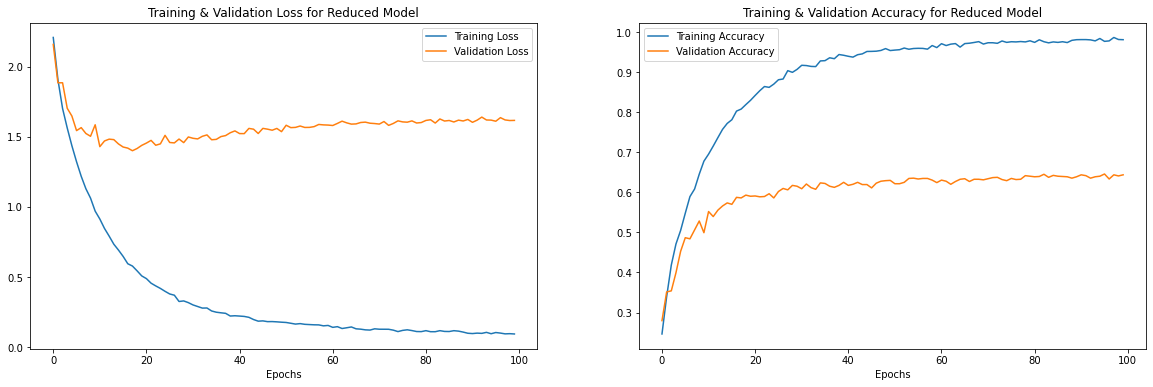

In [558]:
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = reduced_history.history['categorical_accuracy']
train_loss = reduced_history.history['loss']
val_acc = reduced_history.history['val_categorical_accuracy']
val_loss = reduced_history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , val_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss for Reduced Model')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , val_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy for Reduced Model')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

As shown, the training score is approximately **1.00**, and the validation is approximately **0.6**. There is still an overfit, so we will try another solution.

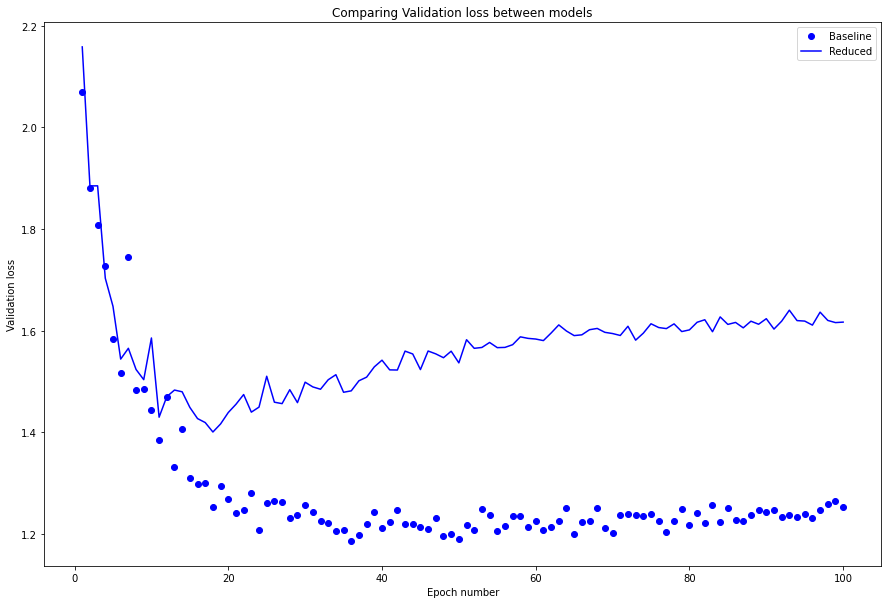

In [559]:
compare_models_by_metric(model4, reduced_model, base_history, reduced_history, 'val_loss')

As seen in the above comparision, the **Base LSTM** loss score lower than **reduced model**.

### Regularized Model 

In the second solution, we will try to use regularized model.

In [560]:
reg_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=9, strides=1, padding='same',kernel_regularizer=regularizers.l2(0.003), input_shape=(X_traind.shape[1],1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Conv1D(filters=64, kernel_size=7, strides=1,kernel_regularizer=regularizers.l2(0.003), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1,kernel_regularizer=regularizers.l2(0.003), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.LSTM(32, return_sequences=True),
    
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(units=16, activation='softmax')
        ])
reg_model._name = 'L2'
reg_history = deep_model(reg_model, X_traind, y_train, X_vald, y_val)
reg_min = optimal_epoch(reg_history)

Minimum validation loss reached in epoch 66


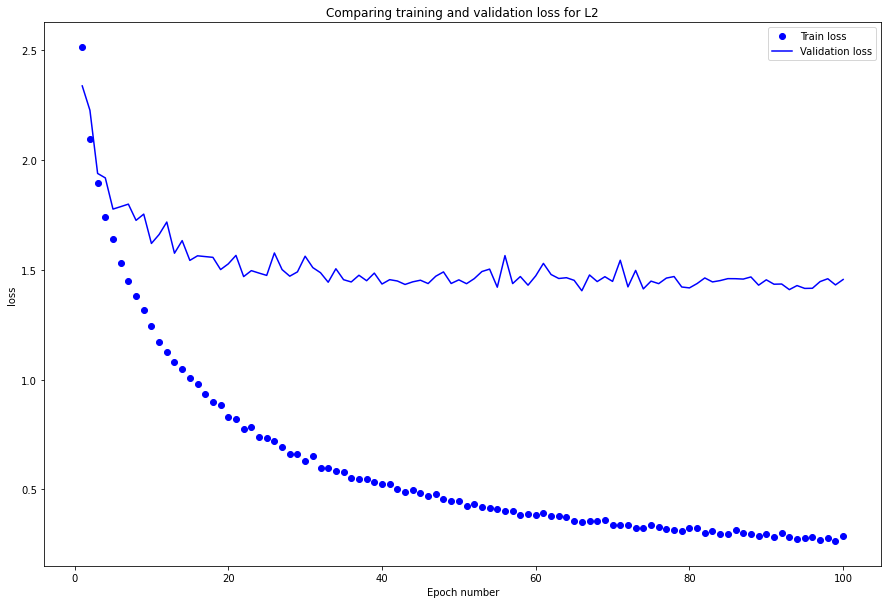

In [561]:
eval_metric(reg_model, reg_history, 'loss')

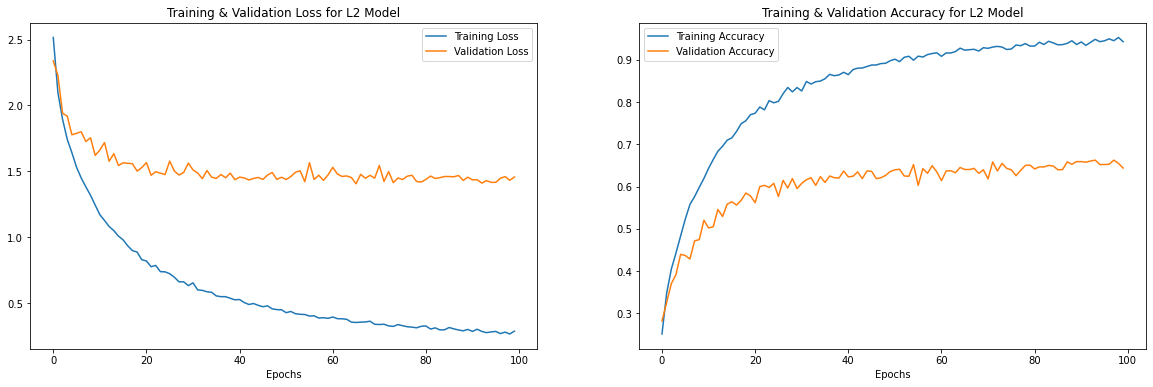

In [562]:
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = reg_history.history['categorical_accuracy']
train_loss = reg_history.history['loss']
val_acc = reg_history.history['val_categorical_accuracy']
val_loss = reg_history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , val_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss for L2 Model')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , val_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy for L2 Model')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

As shown, the training score is almost **1.00**, and the validation is approximately **0.55**. There is still an overfit, so we will try another solution.

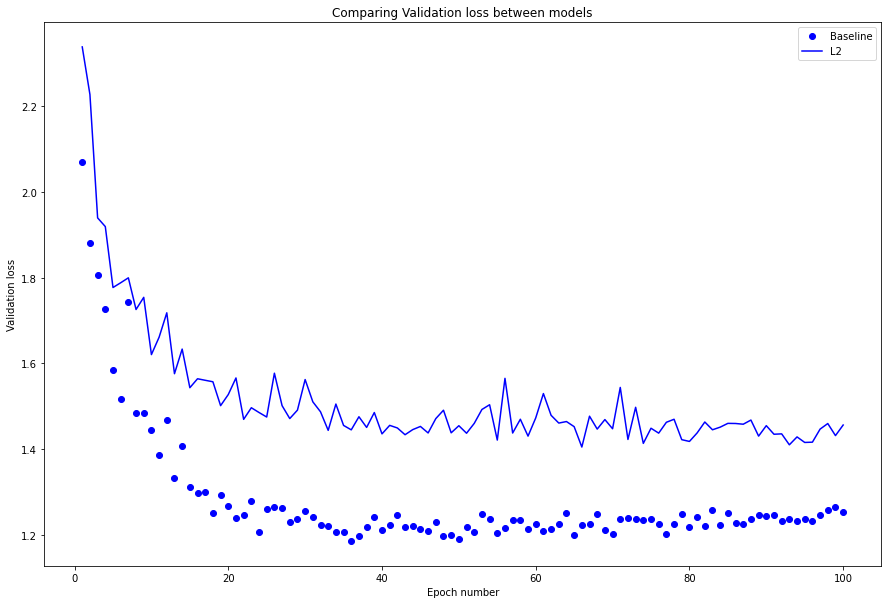

In [563]:
compare_models_by_metric(model4, reg_model, base_history, reg_history, 'val_loss')

As seen in the above comparision, the **Base LSTM** loss score lower than **regularized model**.

### Dropout 

In the third and last solution, we will try to increase the dropout value in all layers.

Minimum validation loss reached in epoch 90


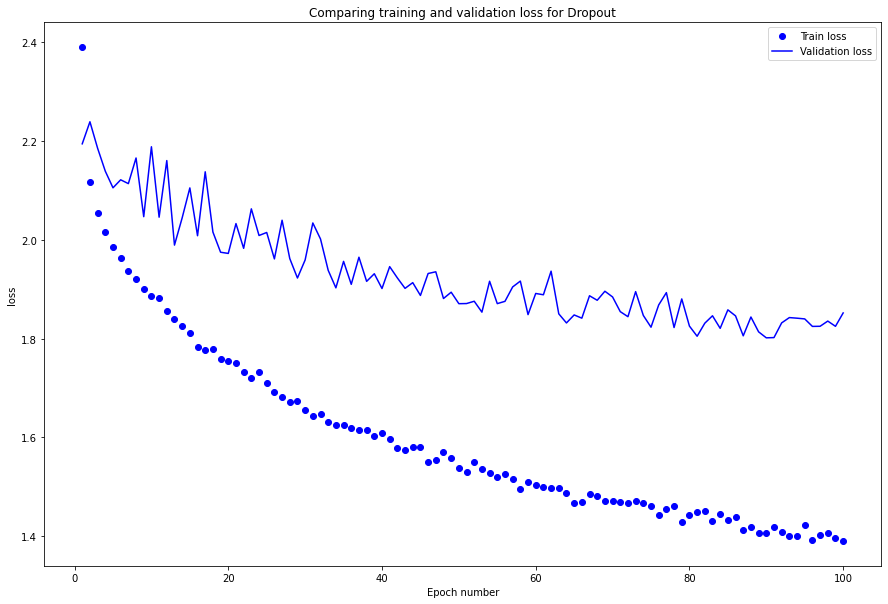

In [564]:
drop_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=9, strides=1, padding='same', input_shape=(X_traind.shape[1],1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.8),
    
        tf.keras.layers.Conv1D(filters=64, kernel_size=7, strides=1, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.9),
        
        tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.6),
    
        tf.keras.layers.LSTM(32, return_sequences=True),
    
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(units=16, activation='softmax')
        ])
drop_model._name = 'Dropout'
drop_history = deep_model(drop_model, X_traind, y_train , X_vald, y_val)
drop_min = optimal_epoch(drop_history)
eval_metric(drop_model, drop_history, 'loss')

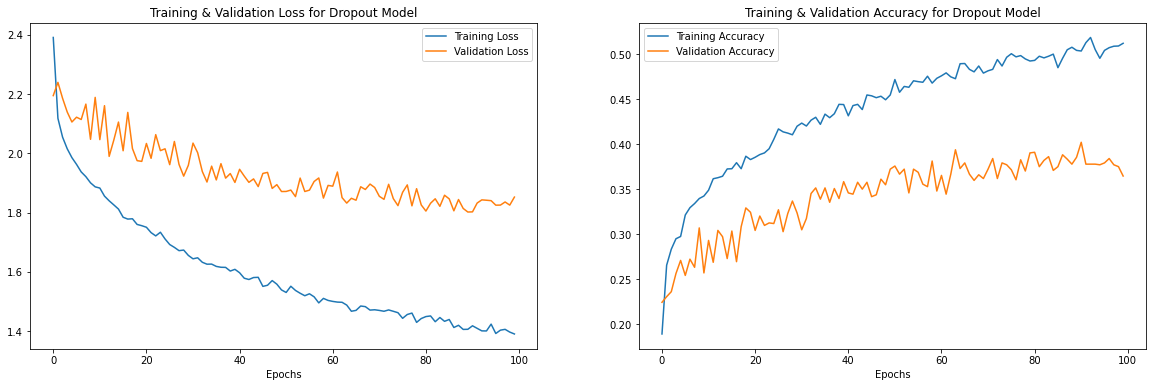

In [565]:
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = drop_history.history['categorical_accuracy']
train_loss = drop_history.history['loss']
val_acc = drop_history.history['val_categorical_accuracy']
val_loss = drop_history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , val_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss for Dropout Model')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , val_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy for Dropout Model')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

As shown, the training score is approximately **0.5**, and the validation is approximately **0.35**. The overfit is decreased but it's still there.

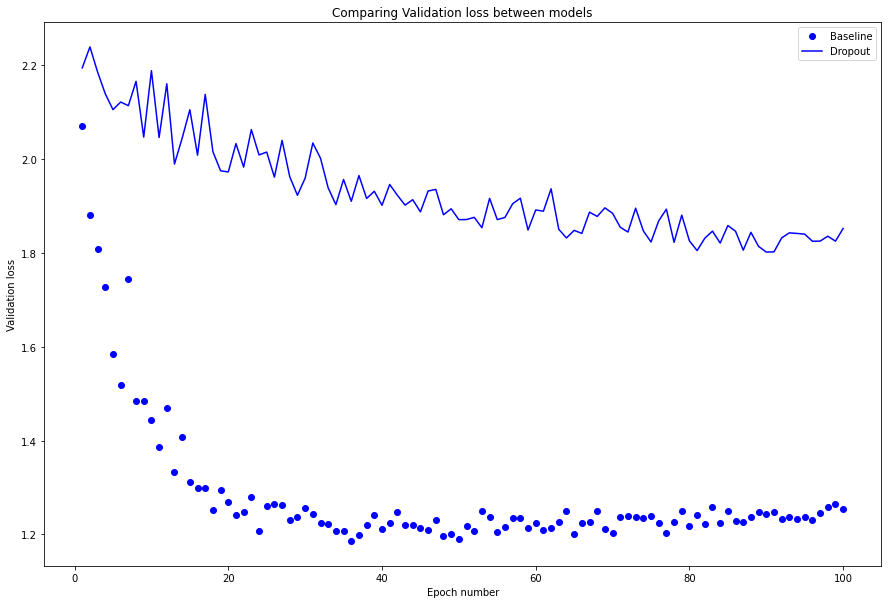

In [566]:
compare_models_by_metric(model4, drop_model, base_history, drop_history, 'val_loss')

As seen in the above comparision, the **Base LSTM** loss score lower than the this solution model.

## Scores for All Tries 

In [567]:
base_results = test_model(model4, X_traind, y_train , X_vald, y_val, X_testd, y_test, base_min)
reduced_results = test_model(reduced_model, X_traind, y_train , X_vald, y_val, X_testd, y_test, reduced_min)
reg_results = test_model(reg_model, X_traind, y_train , X_vald, y_val, X_testd, y_test, reg_min)
drop_results = test_model(drop_model, X_traind, y_train , X_vald, y_val, X_testd, y_test, drop_min)

45/45 [==============================] - 1s 21ms/step - loss: 1.2563 - categorical_accuracy: 0.6833
Train accuracy: 100.00%

Validation accuracy: 70.83%

Test accuracy: 68.33%
45/45 [==============================] - 1s 18ms/step - loss: 1.6481 - categorical_accuracy: 0.6410
Train accuracy: 100.00%

Validation accuracy: 67.22%

Test accuracy: 64.10%
45/45 [==============================] - 1s 13ms/step - loss: 1.4898 - categorical_accuracy: 0.6444
Train accuracy: 99.19%

Validation accuracy: 67.15%

Test accuracy: 64.44%
45/45 [==============================] - 1s 17ms/step - loss: 1.7752 - categorical_accuracy: 0.4118
Train accuracy: 53.19%

Validation accuracy: 43.13%

Test accuracy: 41.18%


There are significantly overfitting in all tried solution. So, we will perform the transfer learning. 

## Transfer Learning 

In this section, we will use **VGG16** model, which deals only with pictures. So, as a first step we will convert the audio files to spectograms pictures.

### Convert audio to image 

In [59]:
def save_fig(path, target):
    spec_path=''
    if target== 'male_happy':
        spec_path= 'emotions/male_happy/'
    elif target== 'male_sad':
        spec_path= 'emotions/male_sad/'
    elif target== 'male_angry':
        spec_path= 'emotions/male_angry/' 
    elif target== 'male_fearful':
        spec_path= 'emotions/male_fearful/' 
    elif target== 'male_calm':
        spec_path= 'emotions/male_calm/' 
    elif target== 'male_neutral':
        spec_path= 'emotions/male_neutral/' 
    elif target== 'male_surprised':
        spec_path= 'emotions/male_surprised/' 
    elif target== 'male_disgust':
        spec_path= 'emotions/male_disgust/' 

    elif target== 'male_happy':
        spec_path= 'emotions/female_happy/' 
    elif target== 'female_sad':
        spec_path= 'emotions/female_sad/'
    elif target== 'female_angry':
        spec_path= 'emotions/female_angry/' 
    elif target== 'female_fearful':
        spec_path= 'emotions/female_fearful/' 
    elif target== 'female_calm':
        spec_path= 'emotions/female_calm/' 
    elif target== 'female_neutral':
        spec_path= 'emotions/female_neutral/'         
    elif target== 'female_surprised':
        spec_path= 'emotions/female_surprised/' 
    elif target== 'female_disgust':
        spec_path= 'emotions/female_disgust/' 
        
        
    fname = path.split('/')[-1].split('.')[0]
    samples, sample_rate = librosa.load(path,sr=None)

    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_axis_off()
    ax.specgram(samples,Fs=2);
    fig.savefig(spec_path+fname)
    plt.close(fig)
    del sample_rate, samples, fig, ax

In [60]:
combined_df.apply(lambda x: save_fig(x.Path, x.Target), axis=1)

/Users/amjad/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7553: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


0       None
1       None
2       None
3       None
4       None
        ... 
7195    None
7196    None
7197    None
7198    None
7199    None
Length: 7200, dtype: object

In [61]:
#change
import glob
male_angry = glob.glob('emotions/male_angry/*.*')
male_calm = glob.glob('emotions/male_calm/*.*')
male_disgust = glob.glob('emotions/male_disgust/*.*')
male_fearful = glob.glob('emotions/male_fearful/*.*')
male_happy = glob.glob('emotions/male_happy/*.*')
male_neutral = glob.glob('emotions/male_neutral/*.*')
male_sad = glob.glob('emotions/male_sad/*.*')
male_surprised = glob.glob('emotions/female_surprised/*.*')
female_angry = glob.glob('emotions/female_angry/*.*')
female_calm = glob.glob('emotions/female_calm/*.*')
female_disgust = glob.glob('emotions/female_disgust/*.*')
female_fearful = glob.glob('emotions/female_fearful/*.*')
female_happy = glob.glob('emotions/female_happy/*.*')
female_neutral = glob.glob('emotions/female_neutral/*.*')
female_sad = glob.glob('emotions/female_sad/*.*')
female_surprised = glob.glob('emotions/female_surprised/*.*')

In the next cells, we will divide the images into train, validation, and test sets.

In [62]:
train_data = []
train_labels = []

for i in male_angry:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Male_angry')
for i in male_calm:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Male_calm')
for i in male_disgust:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Male_disgust')
for i in male_fearful:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Male_fearful')
for i in male_happy:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Male_happy')
for i in male_neutral:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Male_neutral')
for i in male_sad:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Male_sad')
for i in male_surprised:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Male_surprised')
    
for i in female_angry:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Female_angry')
for i in female_calm:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Female_calm')
for i in female_disgust:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Female_disgust')
for i in female_fearful:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Female_fearful')
for i in female_happy:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Female_happy')
for i in female_neutral:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Female_neutral')
for i in female_sad:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Female_sad')
for i in female_surprised:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Female_surprised')


train_data = np.array(train_data)
train_labels = np.array(train_labels)


In [63]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 16

# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                                 batch_size=BATCH_SIZE,
                                                 validation_split=0.25,
                                                 directory=os.path.join('emotions/'),
                                                 shuffle=True,
                                                 color_mode='rgb',
                                                 image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                 subset="training",
                                                 seed=0)
# Make a dataset containing the validation spectrogram

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.25,
                                             directory=os.path.join('emotions/'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

Found 6720 files belonging to 17 classes.
Using 5040 files for training.
Found 6720 files belonging to 17 classes.
Using 1680 files for validation.


In [64]:
X_train_images=train_data
y_train_images=train_labels

In [65]:
val_data = []
val_labels = []

for i in male_angry:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    val_data.append(image)
    val_labels.append('Male_angry')
for i in male_calm:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    val_data.append(image)
    val_labels.append('Male_calm')
for i in male_disgust:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    val_data.append(image)
    val_labels.append('Male_disgust')
for i in male_fearful:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    val_data.append(image)
    val_labels.append('Male_fearful')
for i in male_happy:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    val_data.append(image)
    val_labels.append('Male_happy')
for i in male_neutral:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    val_data.append(image)
    val_labels.append('Male_neutral')
for i in male_sad:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    val_data.append(image)
    val_labels.append('Male_sad')
for i in male_surprised:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    val_data.append(image)
    val_labels.append('Male_surprised')
    
for i in female_angry:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    val_data.append(image)
    val_labels.append('Female_angry')
for i in female_calm:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    val_data.append(image)
    val_labels.append('Female_calm')
for i in female_disgust:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    val_data.append(image)
    val_labels.append('Female_disgust')
for i in female_fearful:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    val_data.append(image)
    val_labels.append('Female_fearful')
for i in female_happy:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    val_data.append(image)
    val_labels.append('Female_happy')
for i in female_neutral:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    val_data.append(image)
    val_labels.append('Female_neutral')
for i in female_sad:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    val_data.append(image)
    val_labels.append('Female_sad')
for i in female_surprised:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    val_data.append(image)
    val_labels.append('Female_surprised')
    
val_data = np.array(val_data)
val_labels = np.array(val_labels)

In [66]:
X_val_images=val_data
y_val_images=val_labels

In [67]:
test_data = []
test_labels = []

for i in male_angry:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Male_angry')
for i in male_calm:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Male_calm')
for i in male_disgust:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Male_disgust')
for i in male_fearful:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Male_fearful')
for i in male_happy:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Male_happy')
for i in male_neutral:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Male_neutral')
for i in male_sad:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Male_sad')
for i in male_surprised:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Male_surprised')
    
for i in female_angry:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Female_angry')
for i in female_calm:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Female_calm')
for i in female_disgust:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Female_disgust')
for i in female_fearful:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Female_fearful')
for i in female_happy:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Female_happy')
for i in female_neutral:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Female_neutral')
for i in female_sad:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Female_sad')
for i in female_surprised:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Female_surprised')
    
test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [68]:
X_test_images=test_data
y_test_images=test_labels

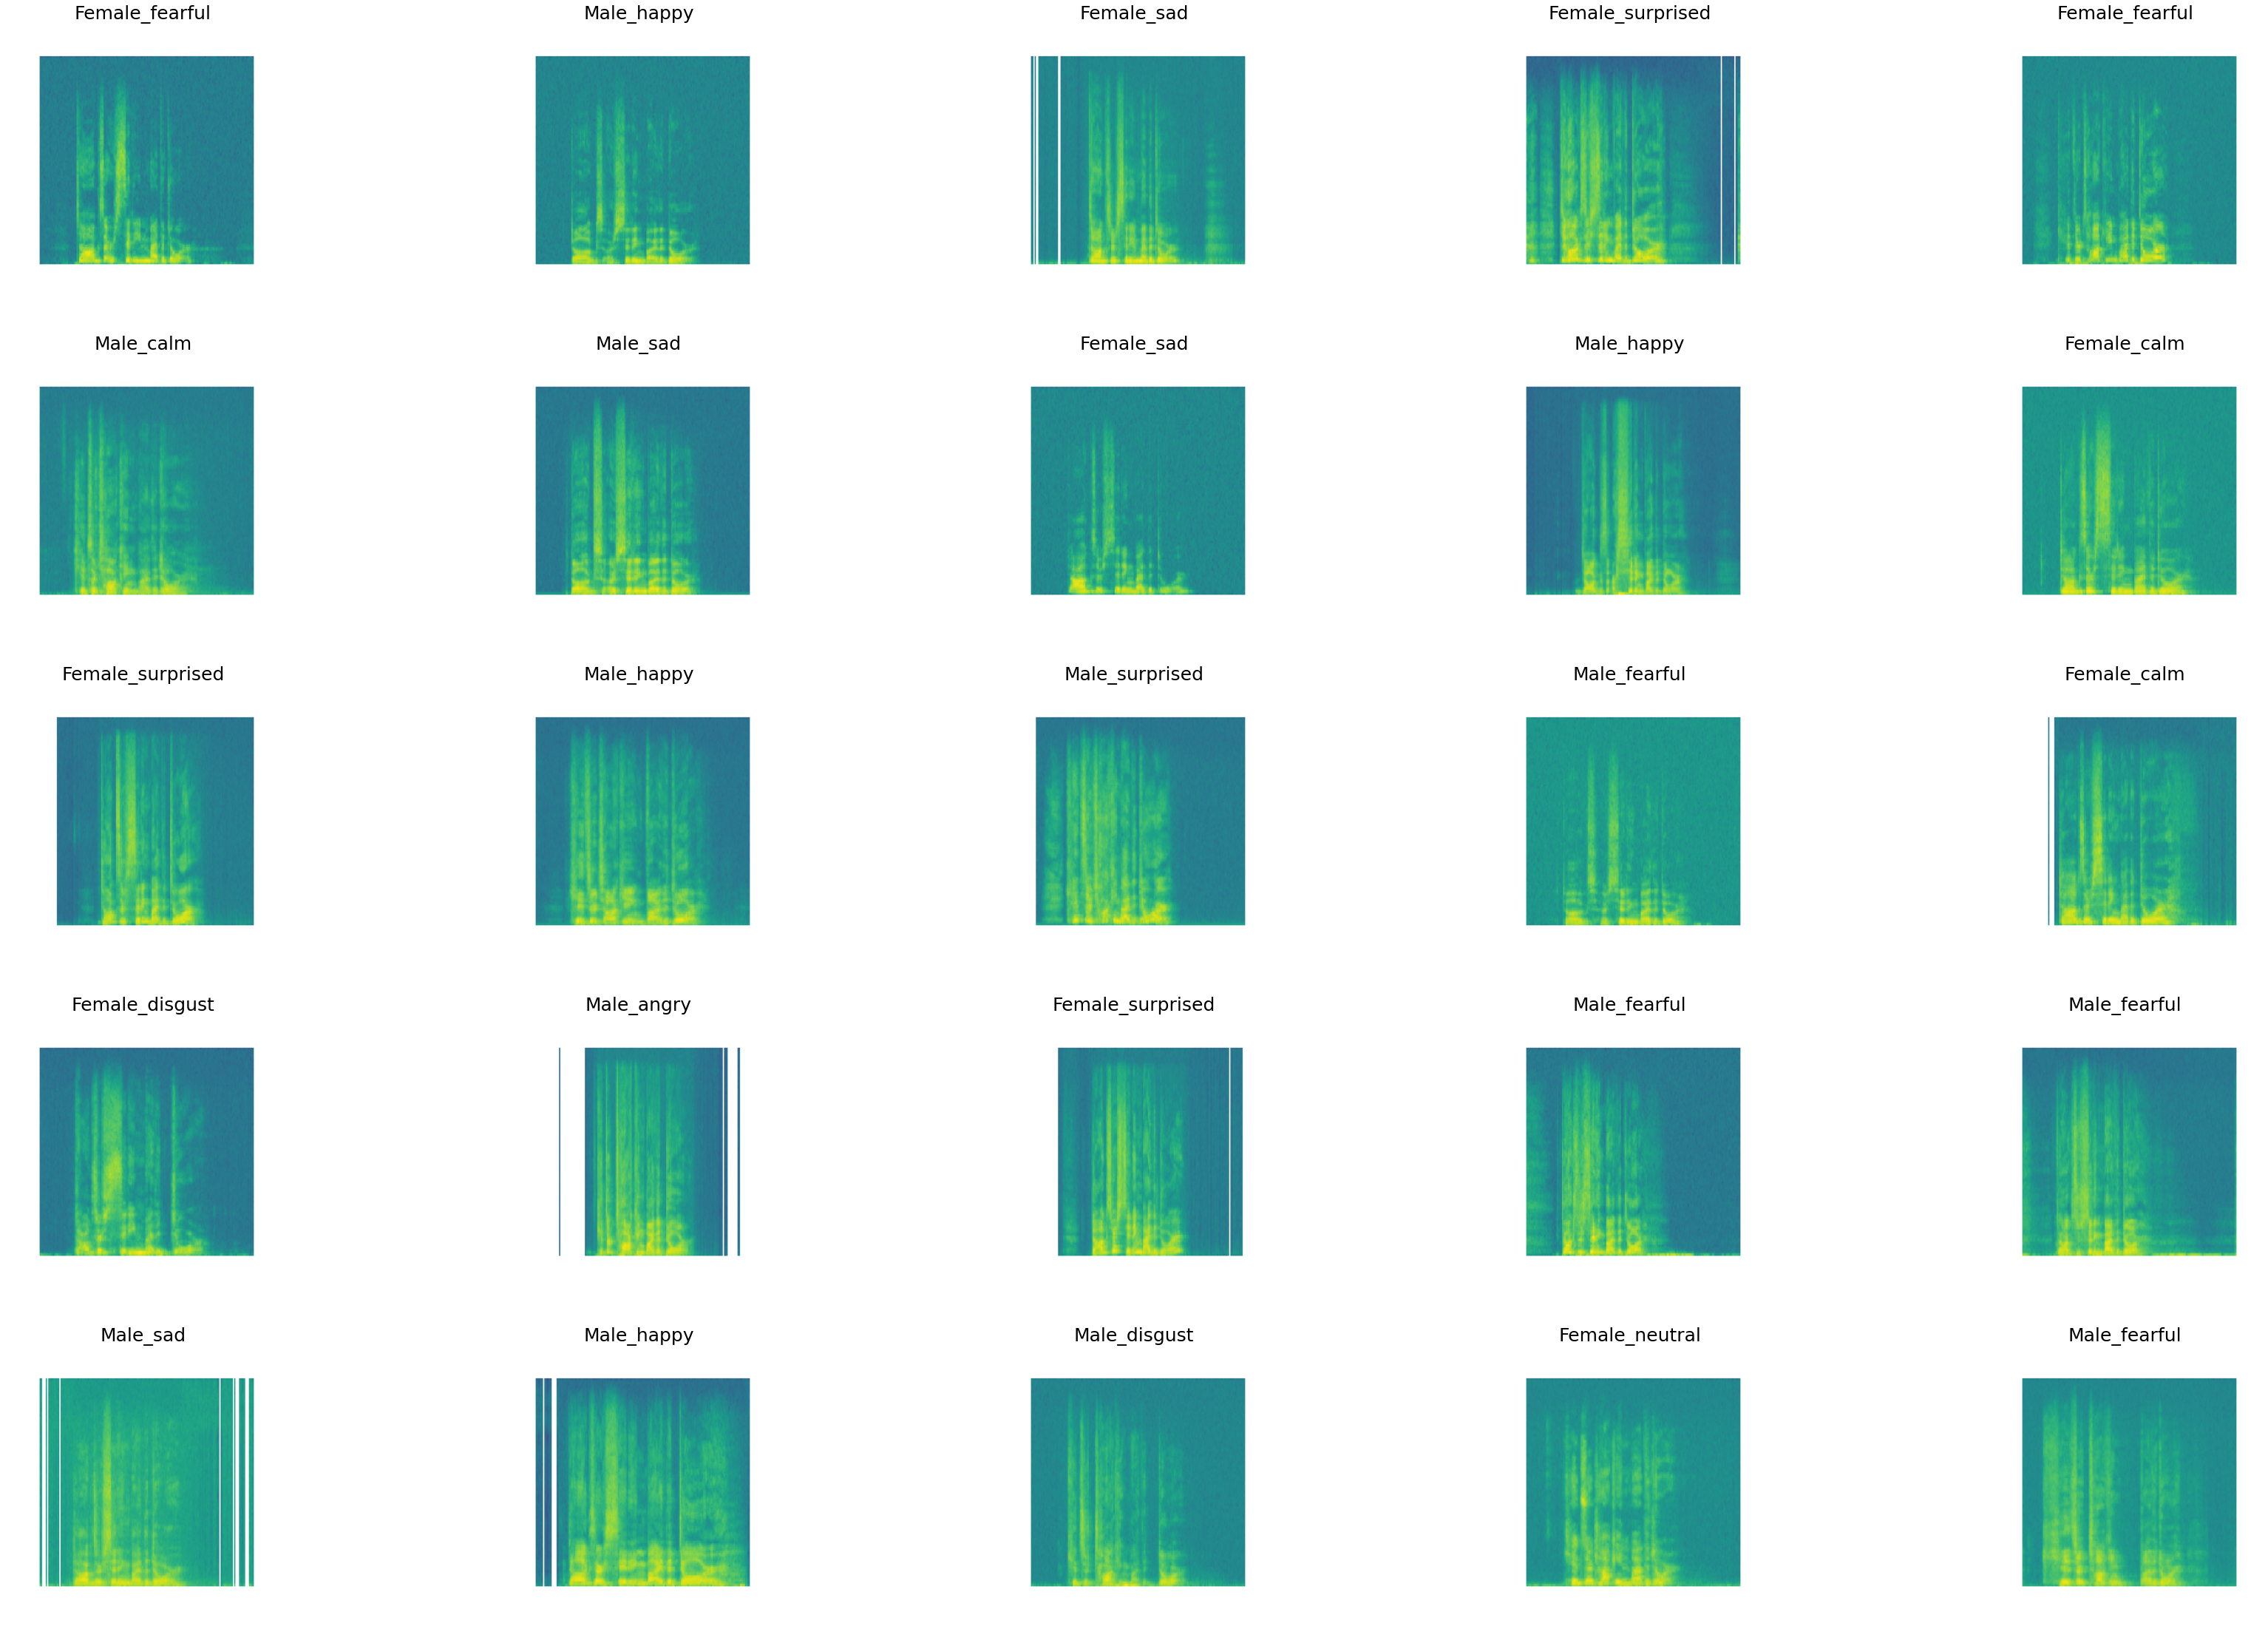

In [69]:
def get_classlabel(class_code):
    labels = {'Male_angry':'Male_angry', 'Male_calm':'Male_calm', 
              'Male_disgust':'Male_disgust', 'Male_fearful':'Male_fearful', 
              'Male_happy':'Male_happy', 'Male_neutral':'Male_neutral','Male_sad':'Male_sad',
              'Male_surprised':'Male_surprised','Female_angry':'Female_angry', 'Female_calm':'Female_calm', 
              'Female_disgust':'Female_disgust', 'Female_fearful':'Female_fearful', 
              'Female_happy':'Female_happy', 'Female_neutral':'Female_neutral','Female_sad':'Female_sad',
              'Female_surprised':'Female_surprised'}
    
    return labels[class_code]
from random import randint
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(train_data))
        ax[i,j].imshow(train_data[rnd_number])
        ax[i,j].set_title(get_classlabel(train_labels[rnd_number]), fontsize=25)
        ax[i,j].axis('off')

In [70]:
# Check shapes of training and testing sets
print('X_train has a shape of {}, y_train has a shape of {}'.format(X_train_images.shape,y_train_images.shape))
print('X_test has a shape of {}, y_test has a shape of {}'.format(X_test_images.shape,y_test_images.shape))

X_train has a shape of (6720, 224, 224, 3), y_train has a shape of (6720,)
X_test has a shape of (6720, 224, 224, 3), y_test has a shape of (6720,)


In [71]:
# Finally, we normalize pixels in X_train and X_test to the range [0,1] for faster convergence
X_train_images = X_train_images.astype('float32')
X_test_images = X_test_images.astype('float32')
X_val_images= X_val_images.astype('float32')
X_train_images /= 255
X_test_images /= 255
X_val_images /=255

### VGG16

Base vgg16 model

In [72]:
vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [73]:
for layer in vgg_model.layers:
    layer.trainable = False

In [77]:
lb = LabelEncoder()

y_train_images = np_utils.to_categorical(lb.fit_transform(y_train_images))
y_test_images = np_utils.to_categorical(lb.fit_transform(y_test_images))
y_val_images =  np_utils.to_categorical(lb.fit_transform(y_val_images))

### VGG Fine Tuning

We will try to fine tuning the vgg16 model. 

In [513]:
# from keras.applications import VGG16
vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))
for layer in vgg_model.layers[:15]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

0 input_24 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [514]:
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dense(15, activation='softmax')(x) # Softmax for multiclass
transfer_model = Model(inputs=vgg_model.input, outputs=x)

In [518]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', 
                              patience = 2, 
                              verbose=1,
                              factor=0.3, 
                              min_lr=0.01)

checkpoint = ModelCheckpoint('finetune.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [519]:
learning_rate= 5e-5
transfer_model.compile(lo
                       ss="categorical_crossentropy",
                       optimizer=optimizers.Adam(lr=learning_rate), metrics=["accuracy"])

/Users/amjad/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [521]:
history = transfer_model.fit(X_train_images, y_train_images, batch_size = 30, epochs=10,
                             validation_data=(X_val_images,y_val_images), callbacks=[lr_reduce,checkpoint])

Epoch 1/10
45/45 [==============================] - ETA: 0s - loss: 0.7058 - accuracy: 0.7225 
Epoch 00001: val_accuracy improved from 0.74702 to 0.77083, saving model to finetune.h15
INFO:tensorflow:Assets written to: finetune.h15/assets
45/45 [==============================] - 1068s 24s/step - loss: 0.7058 - accuracy: 0.7225 - val_loss: 0.5612 - val_accuracy: 0.7708 - lr: 5.0000e-05
Epoch 2/10
45/45 [==============================] - ETA: 0s - loss: 0.6800 - accuracy: 0.7247 
Epoch 00002: val_accuracy improved from 0.77083 to 0.80432, saving model to finetune.h15
INFO:tensorflow:Assets written to: finetune.h15/assets
45/45 [==============================] - 1084s 24s/step - loss: 0.6800 - accuracy: 0.7247 - val_loss: 0.4941 - val_accuracy: 0.8043 - lr: 5.0000e-05
Epoch 3/10
45/45 [==============================] - ETA: 0s - loss: 0.6132 - accuracy: 0.7440 
Epoch 00003: val_accuracy did not improve from 0.80432
45/45 [==============================] - 2441s 55s/step - loss: 0.6132 - a

As shown above, the scores are increased. The training score has become **0.87**, and the validation score almost **0.90**.This model gives us the highest score without overfitting, so we will select it as the best model.   

# Prediction

In this part, we will predict the score on the testing set.

In [92]:
predict=transfer_model.predict(X_testd,batch_size=10)

In [1177]:
emotions=['female_angry', 'female_fearful', 'female_disgust', 'female_sad',
       'female_surprised', 'female_happy', 'female_calm',
       'female_neutral', 'male_neutral', 'male_calm', 'male_happy',
       'male_sad', 'male_disgust', 'male_fearful', 'male_angry',
       'male_surprised']  
 #predicted emotions from the test set  
y_pred = np.argmax(predict, 1)  
predicted_emo=[]   
for i in range(0,y_test.shape[0]):  
    emo=emotions[y_pred[i]]  
    predicted_emo.append(emo)

In [1178]:
print(predicted_emo)

['female_disgust', 'male_sad', 'male_angry', 'female_fearful', 'male_neutral', 'male_sad', 'female_fearful', 'female_angry', 'male_surprised', 'male_disgust', 'female_neutral', 'male_surprised', 'male_angry', 'female_angry', 'female_disgust', 'female_sad', 'male_calm', 'female_calm', 'female_surprised', 'female_fearful', 'female_happy', 'female_disgust', 'male_neutral', 'male_angry', 'male_calm', 'male_fearful', 'female_sad', 'female_calm', 'female_calm', 'male_surprised', 'male_calm', 'male_sad', 'female_angry', 'female_calm', 'female_neutral', 'female_surprised', 'female_calm', 'female_calm', 'male_sad', 'male_happy', 'female_angry', 'male_calm', 'female_fearful', 'male_fearful', 'male_calm', 'male_fearful', 'female_surprised', 'female_surprised', 'male_neutral', 'male_calm', 'female_neutral', 'male_disgust', 'female_angry', 'female_happy', 'male_neutral', 'female_calm', 'male_happy', 'female_surprised', 'male_fearful', 'male_fearful', 'male_angry', 'male_sad', 'female_happy', 'femal

In [1180]:
actual_emo=[]  
y_true=np.argmax(y_test, 1)  
for i in range(0,y_test.shape[0]):  
    emo=emotions[y_true[i]]  
    actual_emo.append(emo)

In [1181]:
print(actual_emo)

['female_angry', 'male_happy', 'male_sad', 'female_fearful', 'male_sad', 'male_sad', 'female_fearful', 'female_angry', 'male_surprised', 'male_disgust', 'female_neutral', 'male_surprised', 'male_angry', 'female_surprised', 'female_surprised', 'female_sad', 'male_calm', 'female_calm', 'female_surprised', 'female_happy', 'female_happy', 'male_sad', 'male_sad', 'male_angry', 'male_calm', 'male_happy', 'female_sad', 'male_angry', 'female_calm', 'male_surprised', 'male_calm', 'male_happy', 'female_sad', 'female_calm', 'female_neutral', 'female_surprised', 'female_calm', 'female_calm', 'male_sad', 'male_happy', 'female_disgust', 'male_happy', 'female_fearful', 'male_calm', 'male_happy', 'male_fearful', 'female_surprised', 'female_surprised', 'male_neutral', 'male_fearful', 'female_neutral', 'male_disgust', 'female_angry', 'female_fearful', 'male_neutral', 'female_calm', 'male_happy', 'female_angry', 'male_angry', 'male_neutral', 'male_fearful', 'male_sad', 'female_fearful', 'female_fearful',

In [1182]:
pre_emo_df = pd.DataFrame (predicted_emo, columns = ['Predicted Emotions'])

In [1183]:
act_emo_df = pd.DataFrame (actual_emo, columns = ['Actucal Emotions'])

In [1184]:
emodf = act_emo_df.join(pre_emo_df)

In [1185]:
emodf

Actucal Emotions Predicted Emotions
0         female_angry     female_disgust
1           male_happy           male_sad
2             male_sad         male_angry
3       female_fearful     female_fearful
4             male_sad       male_neutral
...                ...                ...
1435    female_disgust     female_disgust
1436    female_disgust     female_disgust
1437  female_surprised   female_surprised
1438        male_angry       male_fearful
1439        male_angry         male_happy

[1440 rows x 2 columns]

As shown, the model successfully detected gender, and there is confusion in detection of some emotions.

### Confusion Matrix

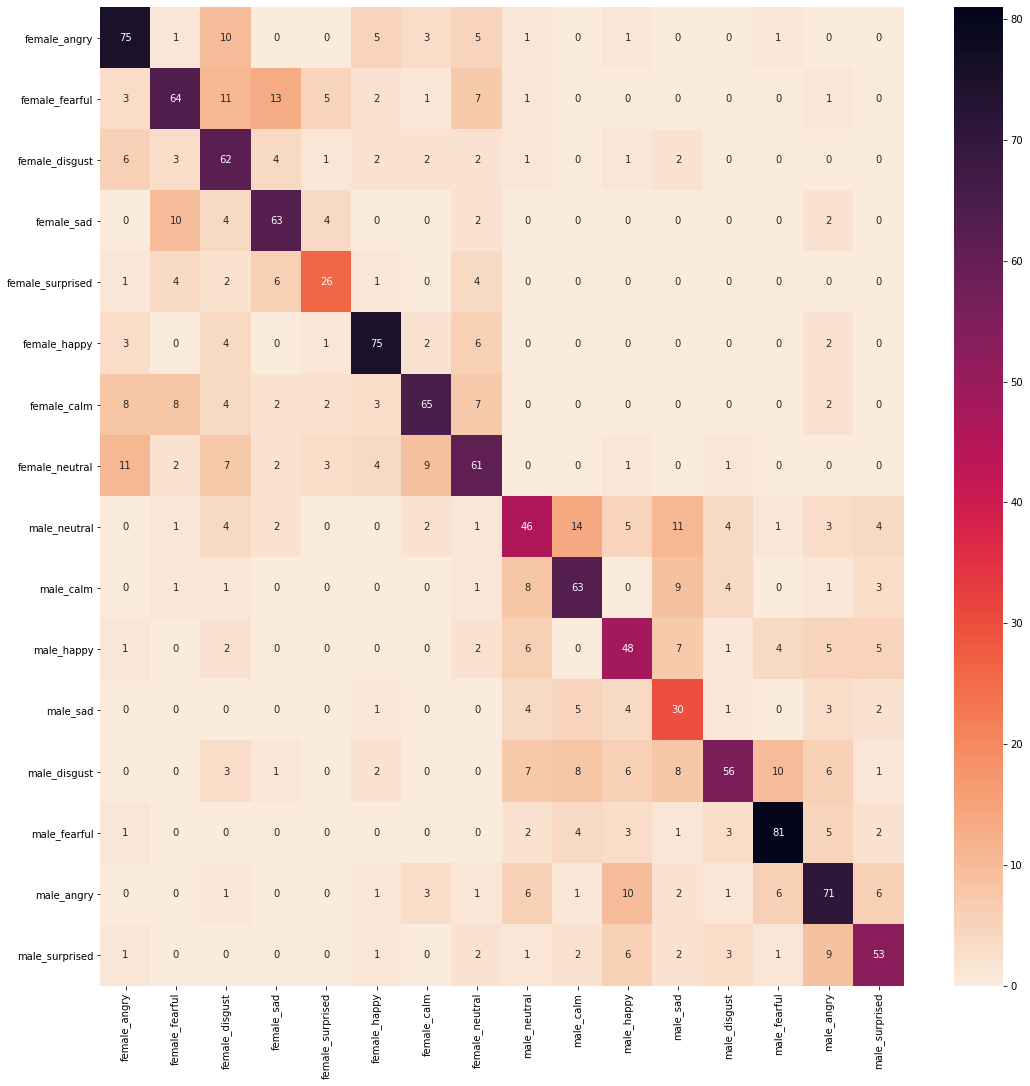

In [1186]:
#generate the confusion matrix  
cm =confusion_matrix(actual_emo, predicted_emo)  
index = ['female_angry', 'female_fearful', 'female_disgust', 'female_sad',
       'female_surprised', 'female_happy', 'female_calm',
       'female_neutral', 'male_neutral', 'male_calm', 'male_happy',
       'male_sad', 'male_disgust', 'male_fearful', 'male_angry',
       'male_surprised']  
columns = ['female_angry', 'female_fearful', 'female_disgust', 'female_sad',
       'female_surprised', 'female_happy', 'female_calm',
       'female_neutral', 'male_neutral', 'male_calm', 'male_happy',
       'male_sad', 'male_disgust', 'male_fearful', 'male_angry',
       'male_surprised']  
cmap = sns.cm.rocket_r
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(18,18))  
sns.heatmap(cm_df, annot=True, cmap=cmap)
plt.savefig('ConfusionMatrix')

In [1187]:
accuracy_score(actual_emo,predicted_emo)

0.6520833333333333